<a href="https://colab.research.google.com/github/lorenzflow/FunctionalDeepLearning/blob/main/CVAE_on_H_spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# connect drive to save models after training
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import EarlyStopping

from sklearn import gaussian_process

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import pairwise_distances
from sklearn.metrics import pairwise_kernels
import scipy.linalg as lin
from scipy.special import zeta
from sklearn.decomposition import PCA
import sklearn.gaussian_process as gp
from scipy.stats import t
from scipy.stats import percentileofscore 
import os
import random
from matplotlib import image
from sklearn.manifold import TSNE

!pip install pycwt
import pycwt

     |████████████████████████████████| 758 kB 5.1 MB/s 
  Created wheel for pycwt: filename=pycwt-0.3.0a22-py3-none-any.whl size=17824 sha256=ec9a1aeb542140a7c6d1d4c59cebb5de535b7173d6263a4d3b56e99a45917286
  Stored in directory: /root/.cache/pip/wheels/53/99/6b/a43c99414482c20862ca8917862237de8bd27ee795a55faa6c
Successfully built pycwt


In [5]:
# This kernel allows comparison in mean and variance
def K_SQR(X,Y,gamma = 1):
    """
    Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
    where T is the map which sends x -> (x,x^{2}) in the Cartesian product of L^{2} with itself.
    
    Parameters:
    X - (n_samples,n_obs) array of samples from the first distribution 
    Y - (n_samples,n_obs) array of samples from the second distribution 
    gamma - bandwidth for the kernel to be used on the two norms, if -1 then median heuristic 
            is used to pick a different gamma for each norm, if gamma = 0 then median heuristic
            is used to pick a single gamma for each norm.
            
    Returns:
    K - matrix formed from the kernel values of all pairs of samples from the two distributions
    """
    n_obs = X.shape[1]
    XY = np.vstack((X,Y))
    dist_mat_1 = (1/np.sqrt(n_obs))*pairwise_distances(XY, metric='euclidean')
    dist_mat_2 = (1/np.sqrt(n_obs))*pairwise_distances(XY**2, metric='euclidean')
    dist_mat = dist_mat_1 + dist_mat_2
    if gamma == 0:
        gamma = np.median(dist_mat[dist_mat > 0])
        K = np.exp(-0.5*(1/gamma**2)*dist_mat**2)
        return K
    if gamma == -1:
        gamma_1 = np.median(dist_mat_1[dist_mat_1 > 0])
        gamma_2 = np.median(dist_mat_2[dist_mat_2 > 0])
        K = np.exp(-0.5*((1/gamma_1**2)*dist_mat_1**2 + (1/gamma_2**2)*dist_mat_2**2))
        return K
    K = np.exp(-0.5*((1/gamma**2)*(dist_mat**2)))
    return K


In [6]:
def cos_exp_kernel(x,y,n_freqs = 5,l=1):
    """
    The c-exp kernel
    
    Parameters:
    x,y - inputs 
    n_freqs - number of frequencies to include in the sum
    l- bandwidth of the kernel
    
    Returns:
    Kernel values given x,y
    """
    
    cos_term = np.sum([np.cos(2*np.pi*n*(x-y)) for n in range(n_freqs)])
    return cos_term*np.exp(-(0.5/(l**2))*(x-y)**2)

def CEXP(X,n_freqs = 20,l=np.sqrt(10)):
    """
    Transforms an array of function values using the integral operator induced by the cos-exp kernel. 
    The function values are assumed to be on [0,1]
    
    Parameters:
    X - (n_samples,n_obs) array of function values
    n_freqs - number of frequencies to include in the sum
    l- bandwidth of the kernel
    
    Returns:
    cos_exp_X - (n_samples,n_obs) array of function values where each function has been passed
                through the integral operator induced by the cos-exp kernel
    """
    n_obs = X.shape[1]
    obs_grid = np.linspace(0,1,n_obs)
    T_mat = pairwise_kernels(obs_grid.reshape(-1,1), metric = cos_exp_kernel, n_freqs = n_freqs,l=l)
    cos_exp_X = (1./n_obs)*np.dot(X,T_mat)
    return cos_exp_X
  
def K_ID(X,Y,gamma=1):
  """
  Forms the kernel matrix K for the two sample test using the SE-T kernel with bandwidth gamma
  where T is the identity operator
  
  Parameters:
  X - (n_samples,n_obs) array of samples from the first distribution 
  Y - (n_samples,n_obs) array of samples from the second distribution 
  gamma - bandwidth for the kernel, if -1 then median heuristic is used to pick gamma
  
  Returns:
  K - matrix formed from the kernel values of all pairs of samples from the two distributions
  """
  n_obs = X.shape[1]
  XY = np.vstack((X,Y))
  dist_mat = (1/np.sqrt(n_obs))*pairwise_distances(XY, metric='euclidean')
  if gamma == -1:
      gamma = np.median(dist_mat[dist_mat > 0])
  
  K = np.exp(-0.5*(1/gamma**2)*(dist_mat**2))
  return K

In [7]:
def MMD_K(K,N,M):
    """
    Calculates the empirical MMD^{2} given a kernel matrix computed from the samples and the sample sizes of each distribution.
    
    Parameters:
    K - kernel matrix of all pairwise kernel values of the two distributions
    N - number of samples from first distribution
    M - number of samples from second distribution
    
    Returns:
    MMDsquared - empirical estimate of MMD^{2}
    """
    
    Kxx = K[:N,:N]
    Kyy = K[N:,N:]
    Kxy = K[:N,N:]
    
    #t1 = (1./(M*(M-1)))*np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t1 = (1./(N*(N-1)))*np.sum(Kxx - np.diag(np.diagonal(Kxx)))
    t2 = (2./(M*N)) * np.sum(Kxy)
    #t3 = (1./(N*(N-1)))* np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    t3 = (1./(M*(M-1)))* np.sum(Kyy - np.diag(np.diagonal(Kyy)))
    
    MMDsquared = (t1-t2+t3)
    
    return MMDsquared

In [8]:
# This kernel allows comparison in mean and variance
def K_Matern(X, length_scale= 1, nu=1.5):
    """
    Computes the Gram matrix for matern kernel

    Parameters:
    X - (n_obs,)  dense grid

            
    Returns:
    K - matrix formed from the kernel values of input grid
    """
    kernel = gp.kernels.Matern(length_scale=length_scale, nu=nu)
    K = kernel.__call__(X)
    
    return K

# eigenvectors of the gram matrix are basis
def evecs(K):
  """
  Computes eigenvectors of 2D array K

  Parameters:
  K - (n,n) array to obtain eigenvectors of

  Returns:
  eigenvalues of K in decreasing order
  eigenvectors of K, ith column is ith evec
  """
  evals, evecs = np.linalg.eig(K)

  return evals,evecs 

# dot basis vectors with observations to obtain coefficients
def matern_basis_transform(data, t_lower=0, t_upper=1, length_scale=1, nu=1.5):
  """
  Transforms the functional input data to a basis defined by the matern kernel

  Parameters:
  data - (n_samples,n_obs) array of observations
  t_lower, t_upper - lower and upper end for time grid
  length_scale - matern kernel lengthscale
  nu - matern kernel parameter

  Returns:
  basis_coeffs - (n_samples, n_evecs) array of coefficients of each observed function with respect to the matern kernel basis
  basis - (n_evecs, n_evecs) array with ith normalised basis vector in ith column
  """
  n_obs = data.shape[1]
  grid_vals = np.linspace(t_lower, t_upper, n_obs) # create grid
  grid_vals = np.expand_dims(grid_vals, axis=-1) # reshape to (n_obs,1)

  Gram_mat = K_Matern(grid_vals, length_scale, nu) # evaluate matern kernel on pairwise distances
  evals, basis = evecs(Gram_mat) # obtain basis by computing evecs of gram matrix

  basis_coeffs = np.matmul(data, basis)

  return basis_coeffs, basis


def FPCA(X,n_comp = 0.95):
    """
    Computes functional principal components of given data up to a specified explained variance level
    
    Parameters:
    X - (n_samples,n_obs) array of function values
    n_comp - number of principal components to compute. If in (0,1) then it is the explained variance level
    
    Returns:
    Normalised eigenvalues, eigenfunctions and the pca object
    """
    n_points = np.shape(X)[1]
    pca = PCA(n_components = n_comp)
    pca.fit(X)
    X_pca = pca.transform(X)
    return (1/n_points)*pca.explained_variance_,pca.components_, pca

def cwt(data, mother = pycwt.MexicanHat(), dt = 1, dj = 1/13, Powers = 7 ):
    """
    Computes continuous wavelet transform of given data
    
    Parameters:
    data - (n_samples,n_obs) array of function values
    mother - Mother wavelet from pycwt package, defaults to Morlet(6)
    dt - timestep, default 1
    dj - size of suboctaves per octave
    Powers - number of poowers of two, ie number of octaves
    

    Returns:
    (n_samples,n_scales, n_obs, 2) array containing continuous wavelet transforms, where n_scales = Powers/dj + 1
     -- note: 2 channels result of stacking real and complex parts of the wavelet transform
    """

    s0 = 2 * dt  # Starting scale, in this case 2 * 0.25 years = 6 months
    J = Powers / dj  # number of powers of two with dj sub-octaves

    n_scales = np.int(J+1)
    n_samples, n_obs = data.shape
    transforms = np.zeros((n_samples, n_scales, n_obs))

    #first time save scales
    wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data[0,:], dt, dj, s0, J,
                                                      mother)
    transforms[0,:,:] = wave.real # discard negligible complex parts

    for i in range(n_samples):
      wave, _, _, _, _, _ = pycwt.cwt(data[i,:], dt, dj, s0, J,
                                                      mother)
      transforms[i,:,:] = wave.real
      #transforms[i,:,:,1] = wave.imag
    return transforms, scales

def icwt(transforms, scales, dt=1, dj=1/13, mother = pycwt.MexicanHat()):

  n_samples,_,n_obs = transforms.shape
  data = np.zeros((n_samples, n_obs))

  for i in range(n_samples):
    wave_real = transforms[i,:,:]
   # wave_imag = transforms[i,:,:,1]
    wave = wave_real #+ 1j * wave_imag

    data[i,:] = pycwt.icwt(wave, scales, dt, dj, mother) #* std

  return data


In [9]:
def transform_data(data, method, num_freq=100, mother='db2'):

  if method == 'fourier':
    # apply fourier transform to data
    # rfft to exploit redundancy for real input and speed up algorithm
    fourier_spectra = np.fft.rfft(data)
    original_fft_length = fourier_spectra.shape[1]
    # truncate after num_freq (0.5% even) frequencies, max can be n//2 + 1
    fourier_spectra_trunc = fourier_spectra[:,:num_freq]
    # concatenate real and imaginary parts and normalise
    real_spectra = fourier_spectra_trunc.real
    imag_spectra = fourier_spectra_trunc.imag
    full_spectra = np.concatenate([real_spectra,imag_spectra], axis=1)

    input_shape = (2*num_freq,)

    return full_spectra, original_fft_length, input_shape

  elif method == 'cwt': # standardise data before?
    transforms, scales = cwt(data)
    return transforms, scales

  elif method == 'dwt': # discrete wavelet transform
    coefs,_ = pywt.dwt(data, wavelet=mother)
    input_shape = (len(coefs), )
    return coefs, mother, input_shape

  elif method == 'fpca':
    # fpca method implemented here assumes dense grid of data
    # fpca explaining 95% of variance
    data_mean = np.mean(data,axis=0)
    data = data - data_mean # fpca requires centered functions (Karhuenen Loeve...)
    _,_,pca = FPCA(data)
    data_pca = pca.transform(data)
    input_shape = (pca.n_components,)

    return data_pca, pca, input_shape

  elif method == 'matern':
    data_matern, basis = matern_basis_transform(data, t_lower=0, t_upper=1, length_scale=1, nu=1.5)
    input_shape = data_matern.shape[1]
    return data_matern, basis, input_shape

  else:
    print('Method not recognised. Choose one of: fourier, cwt, fpca, matern')

In [10]:
def invert_fourier(fourier_data, original_length_of_FFT, normalise_fourier):

  if len(fourier_data.shape)==1:
    num_freq = len(fourier_data)//2
  else:
    num_freq = fourier_data.shape[1]//2

  real_added_complex = (fourier_data[:,:num_freq].numpy() + 1j * fourier_data[:,num_freq:].numpy()) * normalise_fourier

  l = original_length_of_FFT

  inverted = np.fft.irfft(np.concatenate([real_added_complex[:,:], np.zeros((real_added_complex.shape[0],l - num_freq))], axis=1))
  return inverted

def invert_fpca(X, pca):
  return pca.inverse_transform(X)

def invert_matern(basis_coeffs, basis):
  """
  Multiplies basis vectors by coefficients and sums over basis vectors

  Parameters:
  basis_coeffs - (num_samples, dim_bais) array containing basis representation of ith sample in ith row
  basis - (dim_basis, dim_basis) array containing ith basis vector in ith column

  Returns:
  (num_samples, dim_basis) array for which ith row is ith sample representation in standard basis
  """
  return np.matmul(basis_coeffs, np.transpose(basis))

def invert_data(X, method, for_inversion):
  if method == 'fourier':
    original_length_of_FFT = for_inversion
    return invert_fourier(X, original_length_of_FFT, normalise_fourier=1)

  elif method == 'cwt':
    scales = for_inversion
    return icwt(X, scales)

  elif method == 'dwt':
    return pywt.idwt(X, None, wavelet=for_inversion)

  elif method == 'fpca':
    pca = for_inversion
    return invert_fpca(X, pca)

  elif method == 'matern':
    basis = for_inversion
    basis_coeffs = X
    return invert_matern(basis_coeffs, basis)

  else:
    print('Method not recognised. Choose one of: fourier, cwt, fpca, matern')

def invert_scaling(X, scaler):
  return X * scaler

In [11]:

def train_model(method, training_data, latent_dims=10, intermediate_dims=60, lr=0.001, num_epochs=2000, batch_size=25, validation_split=None):
  # doesn't work for convolutional VAE required for CWT
  model_name = method + '_PiVae'
  output_dims = training_data.shape[1]
  if method == 'cwt':
    output_dims = training_data.shape[1:]
    model = CVAE(output_dims, latent_dim=latent_dims, prior='normal')
    loss = reconstruction_loss
  else:
    model = VariationalAutoEncoder(output_dims, intermediate_dims, latent_dims)
    loss=tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(optimizer, loss)
  if validation_split != None:
    early_stopping = EarlyStopping(patience=100)
    hist = model.fit(training_data, training_data, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping])
  else:
    hist = model.fit(training_data, training_data, epochs=num_epochs, batch_size=batch_size);
  return model, hist, model_name

def train_conditional_model(method, training_data, training_labels, latent_dims=10, intermediate_dims=60, lr=0.001, num_epochs=2000, batch_size=25, validation_split=None):
  # doesn't work for convolutional VAE required for CWT
  model_name = method + '_C_PiVae'
  label_dim = training_labels.shape[1]
  output_dims = training_data.shape[1]
  model = ConditionalVAE(output_dims, intermediate_dims, latent_dims, label_dim=label_dim)
  loss=tf.keras.losses.MeanSquaredError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  model.compile(optimizer, loss)

  if validation_split != None:
    early_stopping = EarlyStopping(patience=100)
    hist = model.fit([training_data, training_labels], training_data, epochs=num_epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping])
  else:
    hist = model.fit([training_data, training_labels], training_data, epochs=num_epochs, batch_size=batch_size);
  return model, hist, model_name

In [ ]:
import tensorflow_probability as tfp
tfd = tfp.distributions

def sample_plot(num_samples, models, inversions, scalers, methods, original, latent_dims = 10):

  prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dims), scale=1), reinterpreted_batch_ndims=1)
  all_samples = {}
  for method in methods:
    latent_samples = prior.sample(num_samples)
    model = models[method]
    for_inversion = inversions[method]
    scaler = scalers[method]

    #decode with decoder
    decoded_samples = model.decoder(latent_samples)
    #reverse scaling
    decoded_samples_rescaled = invert_scaling(decoded_samples, scaler)
    #invert transform
    if method == 'dwt':
      decoded_samples_rescaled = decoded_samples_rescaled.numpy()
    final_samples = invert_data(decoded_samples_rescaled, method, for_inversion)
    if method == 'fpca': # for fpca need to add mean back on
      final_samples = final_samples + np.mean(original, axis=0)
    if method == 'cwt':
      ## potntially need to also center first
      final_samples = final_samples
    all_samples[method] = final_samples

  fig, axs = plt.subplots(1, len(methods)+1 , figsize=(20, 7))
  max = np.max(original)
  min = np.min(original)
  for i, ax in enumerate(fig.axes):
    if i>=len(methods):
      ax.plot(np.transpose(original), color='blue', alpha=20/original.shape[0], label='true data')
      ax.set_title('Original Data')
      ax.set_ylim([1.1*min,1.1*max])
    else:
      ax.plot(np.transpose(all_samples[methods[i]]), color='blue', alpha=20/num_samples, label=methods[i])
      ax.set_title(methods[i])
      ax.set_ylim([1.1*min,1.1*max])
    
  fig.suptitle('Samples for different Basis')
  plt.show()
  
  return all_samples

### Load Data set

#### Gridwatch

In [ ]:
file_name='./drive/My Drive/ThesisData/Gridwatch/processed_gridwatch.csv'
gridwatch = pd.read_csv(file_name)

In [ ]:
dates = gridwatch.columns[1:] # extract dates

In [ ]:
gridwatch.head()

timestamp  2011-11-13  2011-11-26  ...  2021-06-02  2021-06-07  2021-06-12
0   00:00:00       29452       32191  ...       21708       21637       21786
1   00:05:00       29592       31846  ...       21736       21605       21709
2   00:10:00       29701       31976  ...       21985       21603       21683
3   00:15:00       29756       32205  ...       22033       21505       21619
4   00:20:00       29755       32263  ...       21872       21504       21678

[5 rows x 533 columns]

In [ ]:
dates = pd.to_datetime(dates, format='%Y-%m-%d') # convert to datetime object
weekdays = dates.weekday # get day of the week

In [ ]:
print(dates[1])
print(weekdays[1])

2011-11-26 00:00:00
5


In [ ]:
np.unique(weekdays, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([62, 61, 73, 64, 81, 96, 95]))

In [ ]:
day_labels = np.zeros((7,len(weekdays.values)))
for i in range(len(weekdays.values)):
  day_labels[weekdays.values[i], i] = 1

In [ ]:
c_grid = day_labels

In [ ]:
X_grid = np.transpose(gridwatch.values[:,1:])

In [ ]:
X_grid = np.array(X_grid, dtype=np.float)

#### Sugar

In [12]:
import glob
import pandas as pd
import numpy as np
file_dir='./drive/My Drive/ThesisData/Sugar_csv'
file_names = glob.glob('{}/wave*'.format(file_dir))

def get_sugar_data(file_names=file_names):
  data = map(pd.read_csv, file_names)
  data = [d.values for d in data]
  return np.stack(data, axis=2)

In [13]:
# load covariates and compute signature
sugar_spectra = get_sugar_data()

In [14]:
sugar_spectra = sugar_spectra[:,1:,:] # fist column is index, so remove
#X_sugar = sugar_spectra[:,:-1,0] # extract one spectra at one frequency
# and removed last point, for simplicity with fourier transform (even)
#original_sugar = X_sugar

In [ ]:
X_sugar = np.concatenate([sugar_spectra[:,:,0], sugar_spectra[:,:,1], sugar_spectra[:,:,2], sugar_spectra[:,:,3], sugar_spectra[:,:,4], 
                            sugar_spectra[:,:,5], sugar_spectra[:,:,6]], axis = 0)


In [ ]:
c_sugar = np.zeros((X_sugar.shape[0],7))
ones = np.ones((sugar_spectra[:,:,0].shape[0],))

for i in range(7):
  c_sugar[i*sugar_spectra[:,:,0].shape[0]:(i+1)*sugar_spectra[:,:,0].shape[0], i] = ones

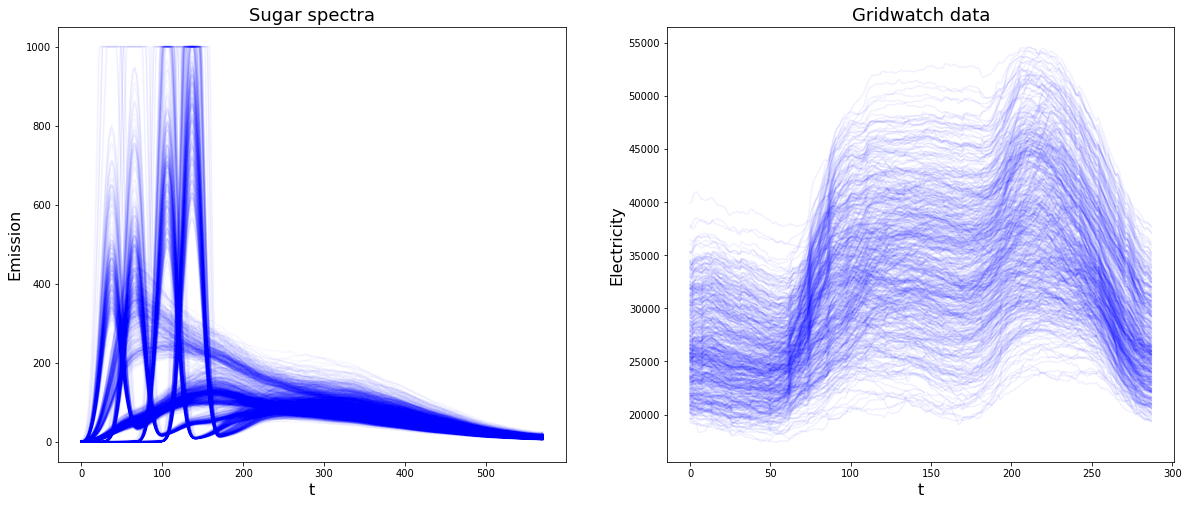

In [ ]:
fig, [ax0, ax1] = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

ax0.plot(np.transpose(X_sugar), alpha=0.03, color='blue')
ax0.set_title('Sugar spectra', fontsize=18)
ax0.set_xlabel('t', fontsize=16)
ax0.set_ylabel('Emission', fontsize=16)


ax1.plot(np.transpose(X_grid), alpha=0.06, color='blue')
ax1.set_title('Gridwatch data', fontsize=18)
ax1.set_xlabel('t', fontsize=16)
ax1.set_ylabel('Electricity', fontsize=16)

plt.show()


### VAE and CVAE classes

In [15]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Model

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    """Signature input to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=10, intermediate_dim=40, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = Dense(intermediate_dim, activation="relu")
        self.bn_1 = BatchNormalization()
        self.dense_proj_1 = Dense(intermediate_dim, activation="relu")
        self.dense_mean = Dense(latent_dim)
        self.dense_log_var = Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        x = self.bn_1(x)
        x = self.dense_proj_1(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded function, back into a function."""

    def __init__(self, original_dim, intermediate_dim=40, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = Dense(intermediate_dim, activation="relu")
        self.bn_1 = BatchNormalization()
        self.dense_proj_1 = Dense(intermediate_dim, activation="relu")
        self.dense_output = Dense(original_dim)

    def call(self, inputs):
        x = self.dense_proj(inputs)
        x = self.bn_1(x)
        x = self.dense_proj_1(x)
        return self.dense_output(x)


class VariationalAutoEncoder(Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)
        #self.mean_list = []
        #self.log_var_list = []

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

class ConditionalVAE(Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        label_dim=7,
        name="conditional_autoencoder",
        **kwargs
    ):
        super(ConditionalVAE, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.label_dim = label_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)
    

    def call(self, inputs):
        x,labels = inputs
        
        z_mean, z_log_var, z = self.encoder(tf.concat([x, labels], axis=1))
        
        
        reconstructed = self.decoder(tf.concat([z, labels], axis=1))
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed



In [16]:
from sklearn.preprocessing import MinMaxScaler
def train_models(training_data, method, latent_dims=10, intermediate_dims=60, 
                 lr=0.005, num_epochs=2400, batch_size=25, num_freq=100, 
                 max_after_scaling = 100, validation_split = None): 

  '''
  Returns:
  trained model, corresponding history object, for_inversion object, scaler
  '''
  train_data = training_data

  if method == 'fpca':
    train_data = training_data - np.mean(training_data,axis=0)

  transformed_data, for_inversion, input_shape = transform_data(train_data, 
                                                                method=method, num_freq = num_freq) 
  # could include more params like matern kernel params...
  # need to scale transformed data, so VAE loss is not NAN (does not tend to infinity from beginning on)
  # from experiments scaling to drastically leads to bad models once scaled back to original scale
  # scale so the maximal coefficient is roughly around 107 seems to work well for fft divide by 1000
  # or just use minmax scaler
  #if method == 'fourier':
    # scaled_transformed = transformed_data/1000 ###need to adjust for other data
  if np.max(np.abs(transformed_data)) <= max_after_scaling:
    scaler = 1
    scaled_transformed = transformed_data
  if method =='cwt':
    max = np.max(transformed_data)
    min = np.min(transformed_data)
    scaled_transformed = (transformed_data - min) / (max - min)
    scaler = (max, min)
  else:
    scaler = np.max(np.abs(transformed_data)) / 100 # scales maximum absolute value to be 100
    scaled_transformed = transformed_data / scaler
    #scaler = MinMaxScaler()
    #scaler.fit(transformed_data)
    #scaled_transformed = scaler.transform(transformed_data)


  model, hist, model_name = train_model(method, scaled_transformed, latent_dims, 
                                        intermediate_dims, lr, num_epochs, batch_size, validation_split=validation_split)


  return model, hist, for_inversion, scaler

def train_conditional_models(training_data, training_labels, method, latent_dims=10, 
                             intermediate_dims=60, lr=0.005, num_epochs=2400, batch_size=25, 
                             num_freq=100, max_after_scaling = 100, validation_split = None): 
  '''
  Returns:
  trained model, corresponding history object, for_inversion object, scaler
  '''
  #methods = ['fourier', 'fpca', 'matern']
  train_data = training_data

  if method == 'fpca':
    train_data = training_data - np.mean(training_data,axis=0)

  transformed_data, for_inversion, input_shape = transform_data(train_data, 
                                                                method=method, num_freq = num_freq) 
  # could include more params like matern kernel params...
  # need to scale transformed data, so VAE loss is not NAN (does not tend to infinity from beginning on)
  # from experiments scaling to drastically leads to bad models once scaled back to original scale
  # scale so the maximal coefficient is roughly around 107 seems to work well for fft divide by 1000
  # or just use minmax scaler
  #if method == 'fourier':
    # scaled_transformed = transformed_data/1000 ###need to adjust for other data
  if np.max(np.abs(transformed_data)) <= max_after_scaling:
    scaler = 1
    scaled_transformed = transformed_data
  if method =='cwt':
    max = np.max(transformed_data)
    min = np.min(transformed_data)
    scaled_transformed = (transformed_data - min) / (max - min)
    scaler = (max, min)
  else:
    scaler = np.max(np.abs(transformed_data)) / 100 # scales maximum absolute value to be 100
    scaled_transformed = transformed_data / scaler
    #scaler = MinMaxScaler()
    #scaler.fit(transformed_data)
    #scaled_transformed = scaler.transform(transformed_data)

  model, hist, model_name = train_conditional_model(method, scaled_transformed, 
                                                    training_labels, latent_dims, 
                                                    intermediate_dims, lr, num_epochs, batch_size,
                                                    validation_split=validation_split)

  return model, hist, for_inversion, scaler

def sample_plot(upsampled_labels, models, inversions, scalers, model_types, original, method='matern', latent_dims = 10):

  prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dims), scale=1), reinterpreted_batch_ndims=1)
  all_samples = {}
  num_samples = upsampled_labels.shape[0]
  for model_type in model_types:
    latent_samples = prior.sample(num_samples)
    model = models[model_type]
    for_inversion = inversions[model_type]
    scaler = scalers[model_type]

    #decode with decoder
    if model_type == 'conditional':
      decoded_samples = model.decoder(tf.concat([latent_samples, upsampled_labels], axis=1))
    else:
      decoded_samples = model.decoder(latent_samples)

    decoded_samples_rescaled = invert_scaling(decoded_samples, scaler)
    #invert transform
    if method == 'dwt':
      decoded_samples_rescaled = decoded_samples_rescaled.numpy()
    final_samples = invert_data(decoded_samples_rescaled, method, for_inversion)
    if method == 'fpca': # for fpca need to add mean back on
      final_samples = final_samples + np.mean(original, axis=0)
    if method == 'cwt':
      ## potntially need to also center first
      final_samples = final_samples
    all_samples[model_type] = final_samples

  fig, axs = plt.subplots(1, len(model_types)+1 , figsize=(20, 7))
  max = np.max(original)
  min = np.min(original)
  for i, ax in enumerate(fig.axes):
    if i>=len(model_types):
      ax.plot(np.transpose(original), color='blue', alpha=20*7/original.shape[0], label='true data')
      ax.set_title('Original Data')
      ax.set_ylim([1.1*min,1.1*max])
    else:
      ax.plot(np.transpose(all_samples[model_types[i]]), color='blue', alpha=20*7/num_samples, label=model_types[i])
      ax.set_title('Samples with {} VAE'.format(model_types[i]))
      ax.set_ylim([1.1*min,1.1*max])
    
  fig.suptitle('Samples for conditional and standard VAE')
  plt.show()
  
  return all_samples

In [ ]:
def sample_C_vae(decoder, prior, num_samples, label, original_length_of_FFT, latent_size, tf_prob=False, normalise_fourier=1, normalise_path=1):

  if prior==None:
    import tensorflow_probability as tfp
    tfd = tfp.distributions
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)
  z = prior.sample(num_samples)
  
  if isinstance(label, int):
    labels = np.zeros((num_samples,7))
    ones = np.ones((num_samples,))
    labels[:,label] = ones
  else:
    labels = label
  concatenated = tf.concat([z, labels], axis=1)

  path_samples = invert_fourier(fourier_samples, original_length_of_FFT, normalise_fourier)

  return path_samples

def plot_CVAE_samples_v_original(original, decoder, prior, label, num_samples, original_length_of_FFT, latent_size, tf_prob=False, normalise_fourier=1, normalise_path=1):

  samples = sample_C_vae(decoder, prior, num_samples, label, original_length_of_FFT, latent_size, tf_prob, normalise_fourier, normalise_path)

  fig, axs = plt.subplots(1, 2, figsize=(14, 5))
  y_upper = np.max([np.max(samples), np.max(original)])
  y_lower = np.min([np.min(samples), np.min(original)])
  for i in range(0,num_samples):
    X_l = np.linspace(0,1259, len(original[i,:]))
    X_f = np.linspace(0,1259, samples.shape[1])
    axs[0].plot(X_f,samples[i,:], color='blue', alpha=0.2)
    axs[1].plot(X_l, original[i,:], color='blue', alpha=0.2)
    axs[0].set_ylim([y_lower,y_upper])
    axs[1].set_ylim([y_lower,y_upper])
  axs[0].set_title('FVAE samples')
  axs[1].set_title('Original Data')
  plt.show()

In [17]:
def PCA_vis(all_samples, original, methods):

  # PCA dimensionality reduction and plot first 2 components
  pca_dummy = PCA(n_components=2)
  original_PCA = pca_dummy.fit_transform(original)

  fig, axs = plt.subplots(1, len(methods), figsize=(25, 6))

  for i, ax in enumerate(fig.axes):
    #pca_dummy = PCA(n_components=2)
    projected = pca_dummy.transform(all_samples[methods[i]][:268,:])
    ax.scatter(projected[:,0], projected[:,1], color='red', label='Synthetic', alpha=0.5)
    ax.scatter(original_PCA[:,0],original_PCA[:,1], color='blue', label = 'original', alpha=0.5)
    ax.set_title('PCA Original vs {} VAE'.format(methods[i]))
    ax.legend(loc='upper right')

  plt.show() 

def TSNE_vis(all_samples, original, methods):
  num_original = original.shape[0]

  fig, axs = plt.subplots(1, len(methods), figsize=(25, 6))

  for i, ax in enumerate(fig.axes):
    TSNE_ = TSNE(n_components=2)
    projected = TSNE_.fit_transform(np.concatenate([original, all_samples[methods[i]][:num_original,:]], axis=0))
    ax.scatter(projected[num_original:,0], projected[num_original:,1], color='red', label='Synthetic', alpha=0.5)
    ax.scatter(projected[:num_original,0],projected[:num_original,1], color='blue', label = 'original', alpha=0.5)
    ax.set_title('t-SNE Original vs {} VAE'.format(methods[i]))
    ax.legend(loc='upper right')

  plt.show() 

def train_and_analyse(data_set, data_labels, data_name, model_types=['conditional', 'standard'],
                      validation_split=None, batch_size=25, 
                      num_samples=3, num_epochs=1800, num_freq=100, 
                      latent_dims = 5, method = 'matern', test_data=None):
  
  print('Performing training and analysis on {}'.format(data_name))
  original = data_set
  # if specified us a cut of the training data set as validation set

  models = {}
  histories = {}
  inversions = {}
  scalers = {}
  models['conditional'], histories['conditional'], inversions['conditional'], scalers['conditional'] = train_conditional_models(data_set, data_labels, 
                                                                                                            latent_dims=latent_dims, 
                                                                                                            intermediate_dims=100, 
                                                                                                            lr=0.005, 
                                                                                                            validation_split=validation_split, 
                                                                                                            num_epochs=num_epochs, 
                                                                                                            num_freq=num_freq, 
                                                                                                            batch_size=batch_size, 
                                                                                                            method=method) 
  models['standard'], histories['standard'], inversions['standard'], scalers['standard'] = train_models(data_set, latent_dims=latent_dims, 
                                                                                                          intermediate_dims=100, 
                                                                                                          lr=0.005, num_epochs=num_epochs, 
                                                                                                          num_freq=num_freq, 
                                                                                                          batch_size=batch_size, 
                                                                                                          method=method, validation_split=validation_split)
  print('Training complete')
  # plot training loss
  if validation_split != None:
    fig, [ax0,ax1] = plt.subplots(1,2, figsize=(20,8))
    ax0.plot(np.log(histories['conditional'].history['loss']), label='Train Loss')
    ax0.plot(np.log(histories['conditional'].history['val_loss']), label='Val Loss')
    ax0.set_title('Loss vs Epochs for conditional VAE')
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('log(Loss)')
    ax0.legend(loc='upper right')
    ax1.plot(np.log(histories['standard'].history['loss']), label='Train Loss')
    ax1.plot(np.log(histories['standard'].history['val_loss']), label='Val Loss')
    ax1.set_title('Loss vs Epochs for VAE')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('log(Loss)')
    ax1.legend(loc='upper right')

  else:
    fig, [ax0,ax1] = plt.subplots(1,2, figsize=(20,8))
    ax0.plot(np.log(histories['conditional'].history['loss']), label='Train Loss')
    ax0.set_title('Loss vs Epochs for conditional VAE')
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('log(Loss)')
    ax0.legend(loc='upper right')
    ax1.plot(np.log(histories['standard'].history['loss']), label='Train Loss')
    ax1.set_title('Loss vs Epochs for VAE')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('log(Loss)')
    ax1.legend(loc='upper right')
  
  print('Generating samples')

  upsampled_labels = np.concatenate([data_labels]*num_samples, axis = 0)
  num_vae_samples = upsampled_labels.shape[0]
  all_samples = sample_plot(upsampled_labels, models, inversions, scalers, model_types, original, method=method, latent_dims = latent_dims)

  # incase of synthetic data set use an unseen newly generated data set for comparison
  try:
    if isinstance(test_data,np.ndarray):
        original = test_data
  except NameError:
      print("FALSE")

  # project samples and original into first two functional principal components and plot
  PCA_vis(all_samples, original, model_types)
  # t-SNE and plot
  TSNE_vis(all_samples, original, model_types)
  print('computing MMD')
  MMD_values = {}
  for model_type in model_types:
    gamma=-1
    mmd = MMD_K(K_SQR(original, all_samples[model_type]), original.shape[0], all_samples[model_type].shape[0])
    print('MMD between original data and {} samples with {} model is: {}'.format(all_samples[model_type].shape[0], model_type, mmd))
    MMD_values[model_type] = mmd

  return all_samples, MMD_values, models, histories, inversions, scalers

In [ ]:
X_sugar_train, X_sugar_test, c_sugar_train, c_sugar_test = train_test_split(
    X_sugar, c_sugar, test_size=0.3, random_state=42, stratify=c_sugar)

Performing training and analysis on sugar
Epoch 1/600
14/14 [==============================] - 1s 6ms/step - loss: 269.5195
Epoch 2/600
14/14 [==============================] - 0s 5ms/step - loss: 59.1859
Epoch 3/600
14/14 [==============================] - 0s 4ms/step - loss: 31.6595
Epoch 4/600
14/14 [==============================] - 0s 4ms/step - loss: 19.0319
Epoch 5/600
14/14 [==============================] - 0s 6ms/step - loss: 19.7255
Epoch 6/600
14/14 [==============================] - 0s 5ms/step - loss: 22.1624
Epoch 7/600
14/14 [==============================] - 0s 5ms/step - loss: 15.6885
Epoch 8/600
14/14 [==============================] - 0s 5ms/step - loss: 13.5562
Epoch 9/600
14/14 [==============================] - 0s 5ms/step - loss: 13.6244
Epoch 10/600
14/14 [==============================] - 0s 5ms/step - loss: 12.7114
Epoch 11/600
14/14 [==============================] - 0s 6ms/step - loss: 12.6924
Epoch 12/600
14/14 [==============================] - 0s 6ms/ste

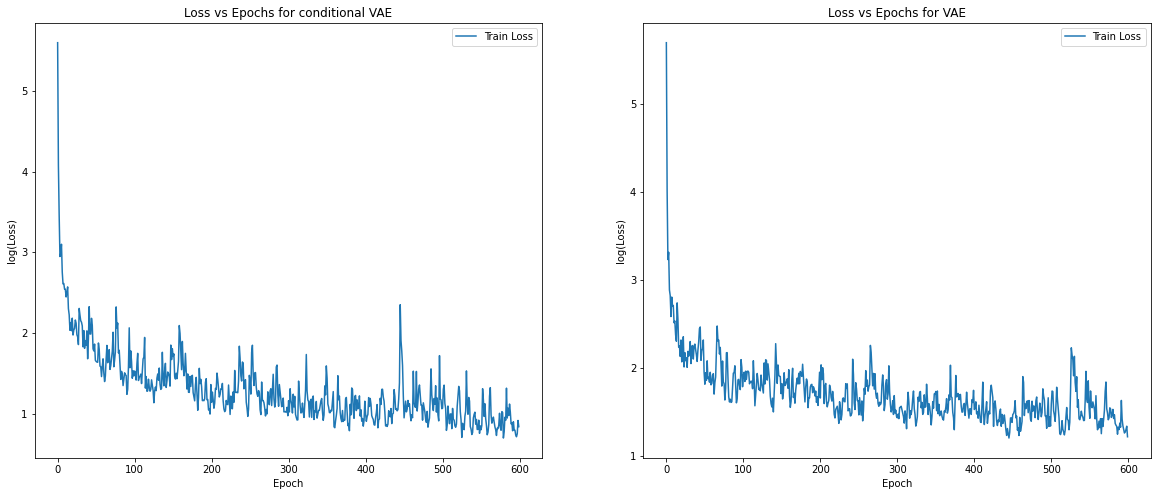

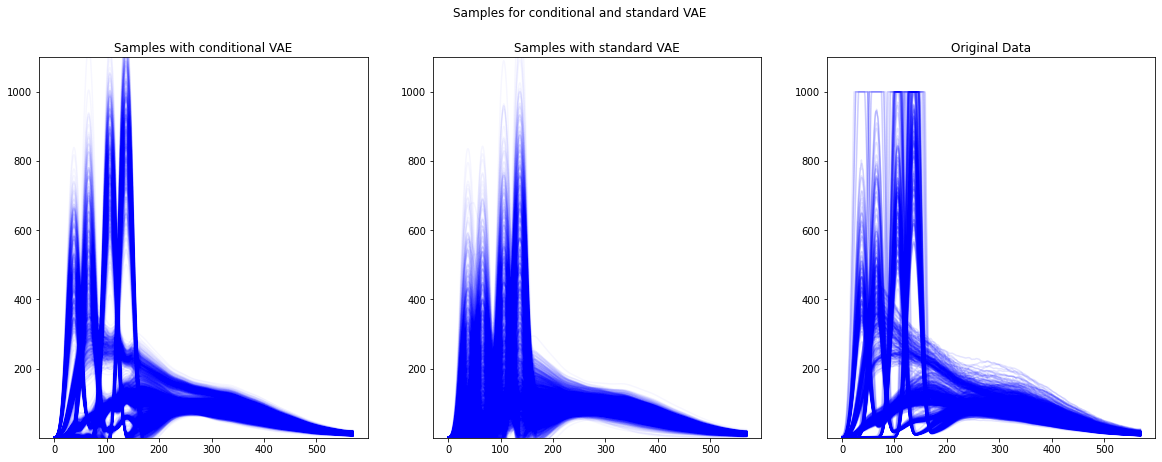

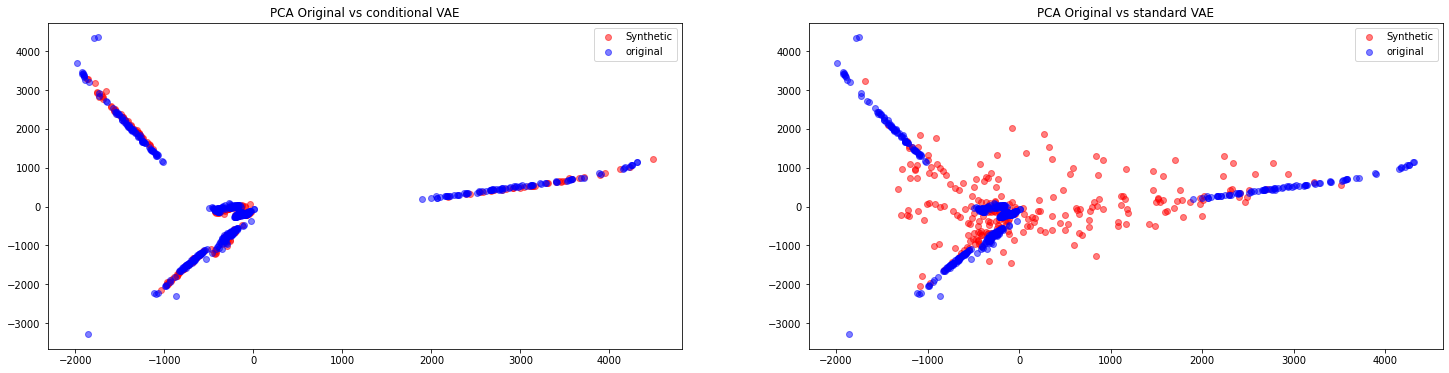

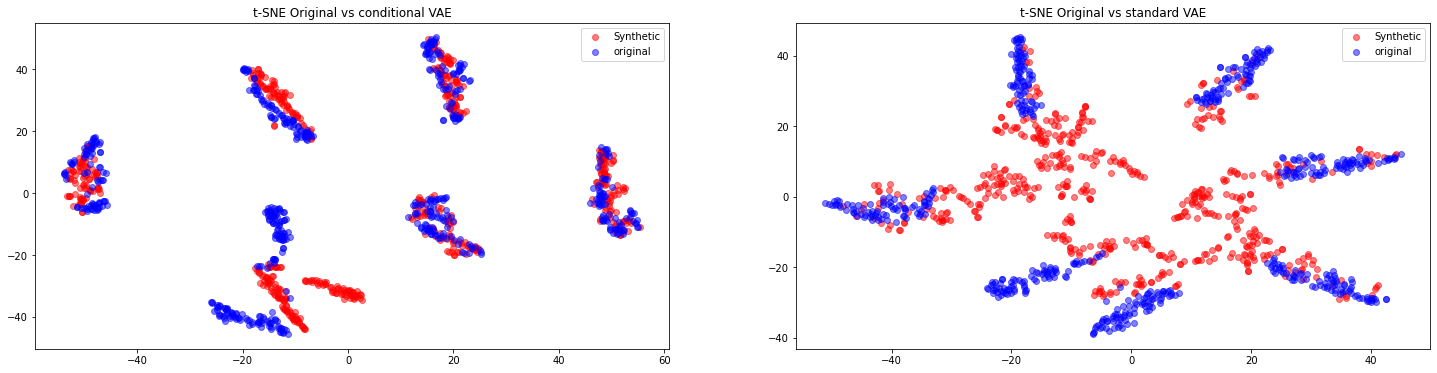

computing MMD
MMD between original data and 3939 samples with conditional model is: 3.740500941837288e-25
MMD between original data and 3939 samples with standard model is: 1.0083906045010608e-213


In [ ]:
#results = {}

results['sugar'] = train_and_analyse(X_sugar_train[:,:-1], c_sugar_train, 'sugar', model_types=['conditional', 'standard'],
                      validation_split=None, batch_size=100, 
                      num_samples=3, num_epochs=600, num_freq=100, 
                      latent_dims = 5, method = 'fpca', test_data=X_sugar_test[:,:-1])

In [ ]:
X = CEXP(X_sugar[:,:-1])
for model_type in ['conditional', 'standard']:
    N = X_sugar[:,:-1].shape[0]
    M = results['sugar'][0][model_type][:N,:].shape[0]
    Y = CEXP(results['sugar'][0][model_type][:N,:])
    K = K_ID(X,Y)
    #gamma=1
    #K = K_SQR(gridwatch_data[:,:100], results['gridwatch'][0][method][:2000,:100])
    mmd = MMD_K(K, N, M)
    print('MMD between original data and {} samples with {} basis is: {}'.format(M, model_type, mmd))


MMD between original data and 1876 samples with conditional basis is: 0.004404654028569813
MMD between original data and 1876 samples with standard basis is: 0.001276152232075697


Performing training and analysis on sugar
Epoch 1/600
14/14 [==============================] - 2s 13ms/step - loss: 7.8700
Epoch 2/600
14/14 [==============================] - 0s 9ms/step - loss: 3.6397
Epoch 3/600
14/14 [==============================] - 0s 11ms/step - loss: 1.6602
Epoch 4/600
14/14 [==============================] - 0s 13ms/step - loss: 0.9578
Epoch 5/600
14/14 [==============================] - 0s 13ms/step - loss: 0.6989
Epoch 6/600
14/14 [==============================] - 0s 11ms/step - loss: 0.6094
Epoch 7/600
14/14 [==============================] - 0s 10ms/step - loss: 0.5346
Epoch 8/600
14/14 [==============================] - 0s 11ms/step - loss: 0.5080
Epoch 9/600
14/14 [==============================] - 0s 11ms/step - loss: 0.4598
Epoch 10/600
14/14 [==============================] - 0s 12ms/step - loss: 0.4484
Epoch 11/600
14/14 [==============================] - 0s 10ms/step - loss: 0.4239
Epoch 12/600
14/14 [==============================] - 0s 11ms/step

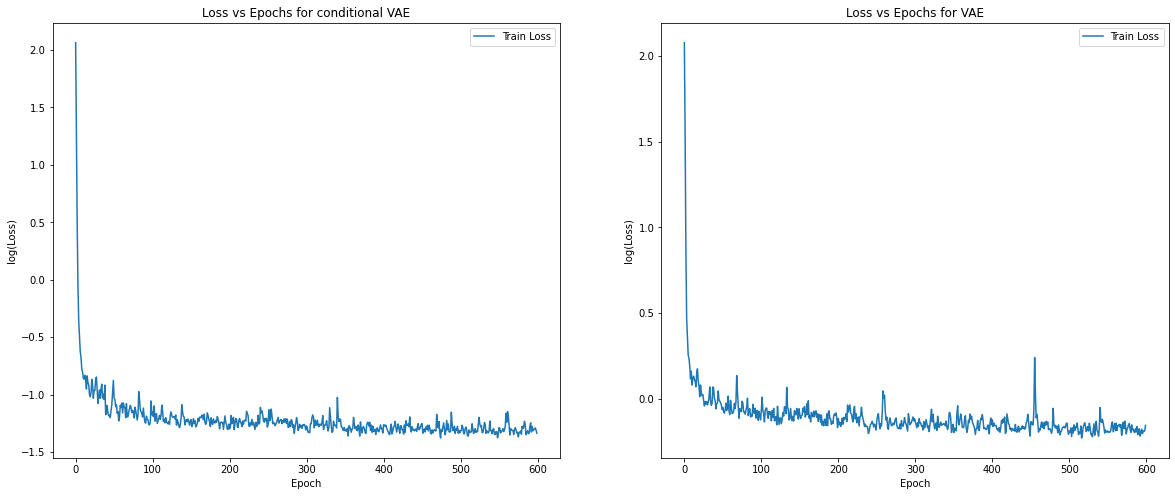

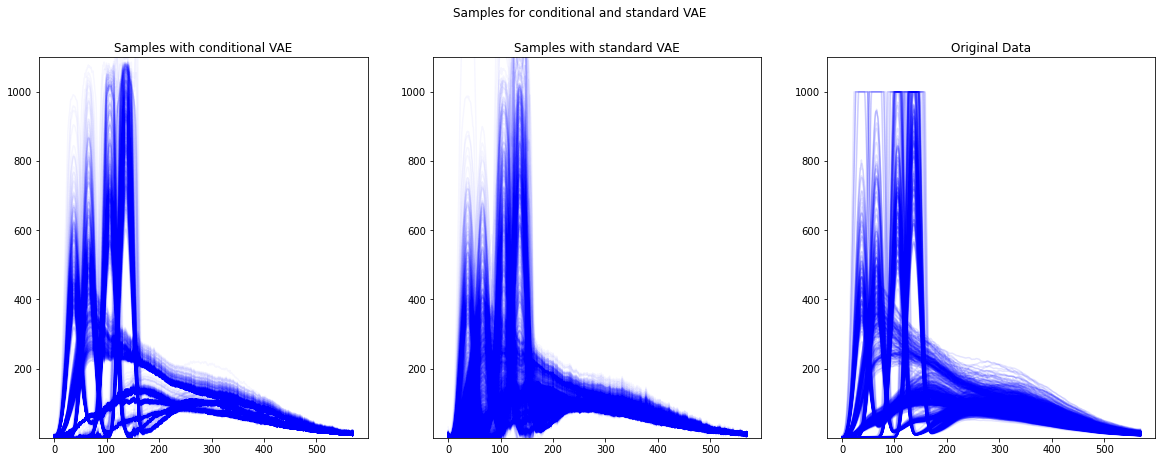

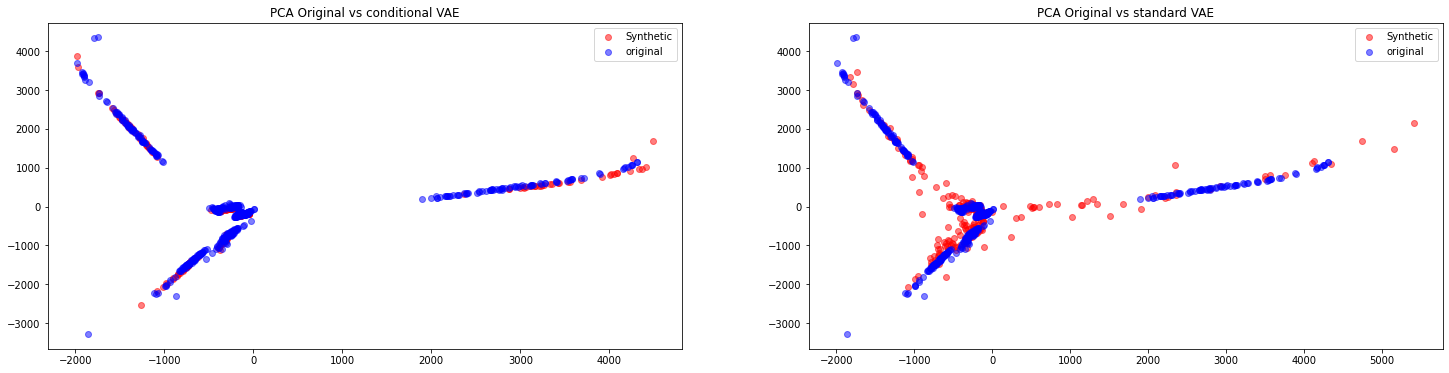

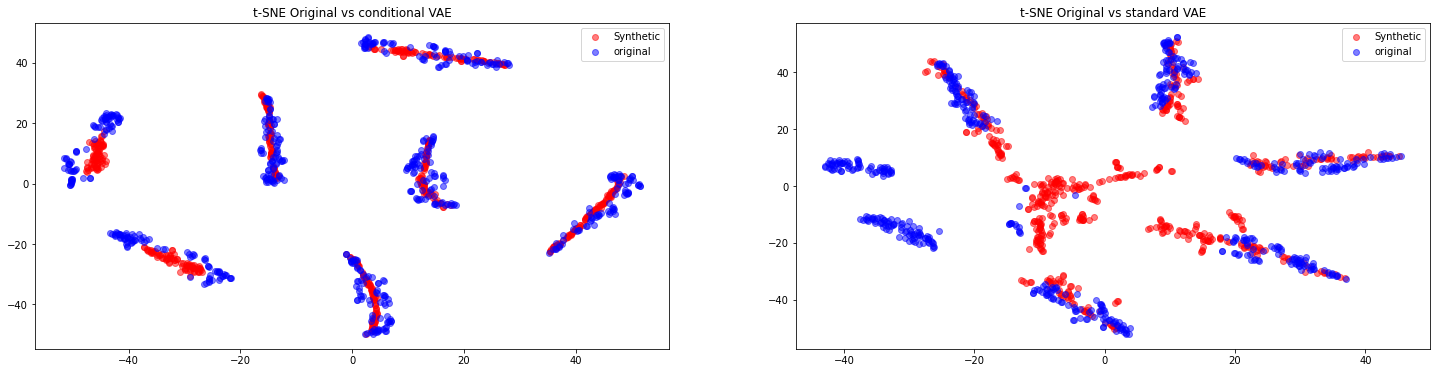

computing MMD
MMD between original data and 3939 samples with conditional model is: 2.774630303432933e-22
MMD between original data and 3939 samples with standard model is: 1.6542392312640531e-227


In [ ]:
results['sugar_matern'] = train_and_analyse(X_sugar_train[:,:-1], c_sugar_train, 'sugar', model_types=['conditional', 'standard'],
                      validation_split=None, batch_size=100, 
                      num_samples=3, num_epochs=600, num_freq=100, 
                      latent_dims = 5, method = 'matern', test_data=X_sugar_test[:,:-1])

In [ ]:
X = CEXP(X_sugar_test[:,:-1])
for model_type in ['conditional', 'standard']:
    M = results['sugar_matern'][0][model_type][:,:].shape[0]
    Y = CEXP(results['sugar_matern'][0][model_type][:,:])
    K = K_ID(X,Y)
    #gamma=1
    #K = K_SQR(gridwatch_data[:,:100], results['gridwatch'][0][method][:2000,:100])
    mmd = MMD_K(K, X_sugar_test[:,:].shape[0], M)
    print('MMD between original data and {} samples with {} basis is: {}'.format(M, model_type, mmd))


MMD between original data and 3939 samples with conditional basis is: 0.019376740679443227
MMD between original data and 3939 samples with standard basis is: 0.002719218393841115


Performing training and analysis on sugar
Epoch 1/600
14/14 [==============================] - 2s 9ms/step - loss: 15.4566
Epoch 2/600
14/14 [==============================] - 0s 9ms/step - loss: 6.8664
Epoch 3/600
14/14 [==============================] - 0s 9ms/step - loss: 2.6730
Epoch 4/600
14/14 [==============================] - 0s 7ms/step - loss: 1.7838
Epoch 5/600
14/14 [==============================] - 0s 9ms/step - loss: 1.2027
Epoch 6/600
14/14 [==============================] - 0s 8ms/step - loss: 1.0992
Epoch 7/600
14/14 [==============================] - 0s 9ms/step - loss: 0.9583
Epoch 8/600
14/14 [==============================] - 0s 10ms/step - loss: 0.8555
Epoch 9/600
14/14 [==============================] - 0s 10ms/step - loss: 0.7977
Epoch 10/600
14/14 [==============================] - 0s 11ms/step - loss: 0.7684
Epoch 11/600
14/14 [==============================] - 0s 13ms/step - loss: 0.7185
Epoch 12/600
14/14 [==============================] - 0s 13ms/step - lo

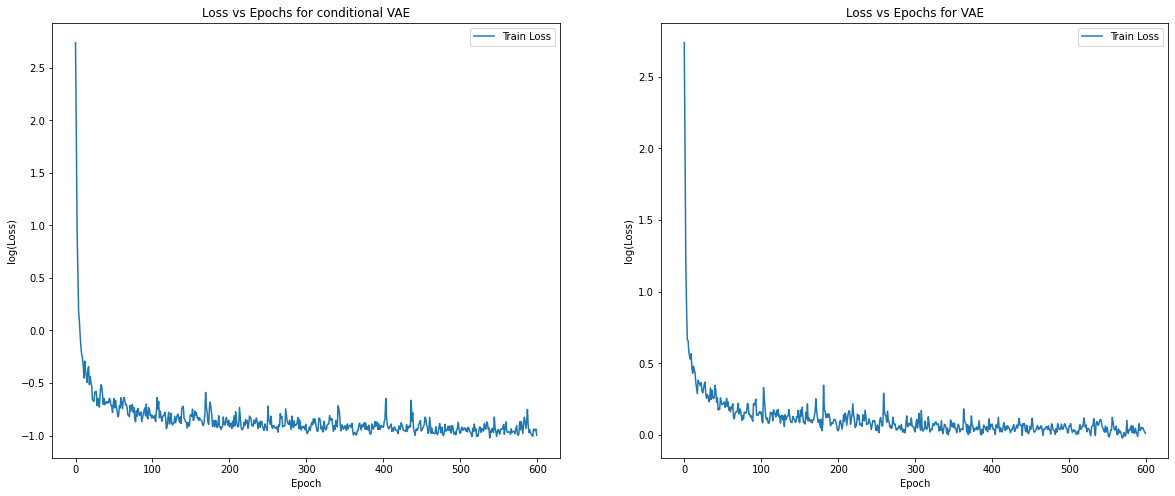

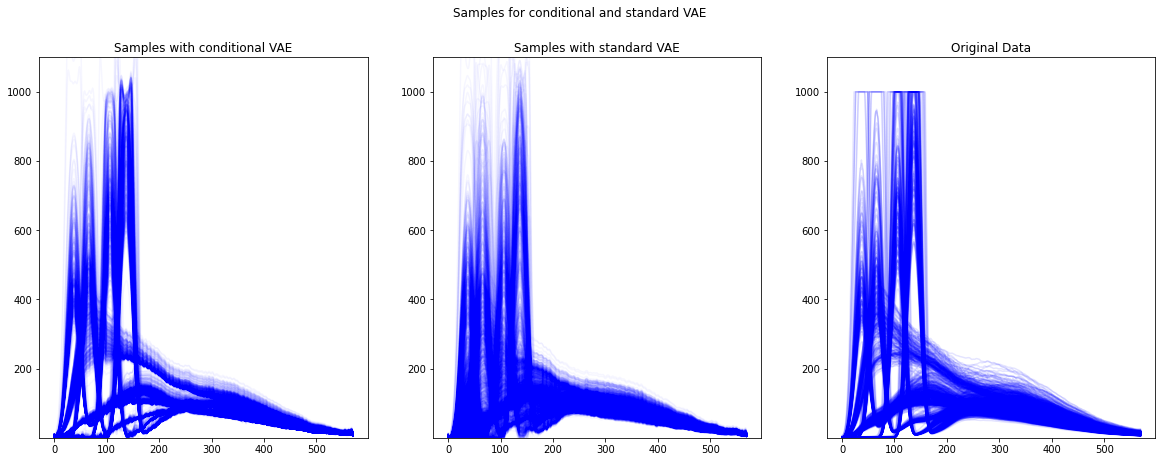

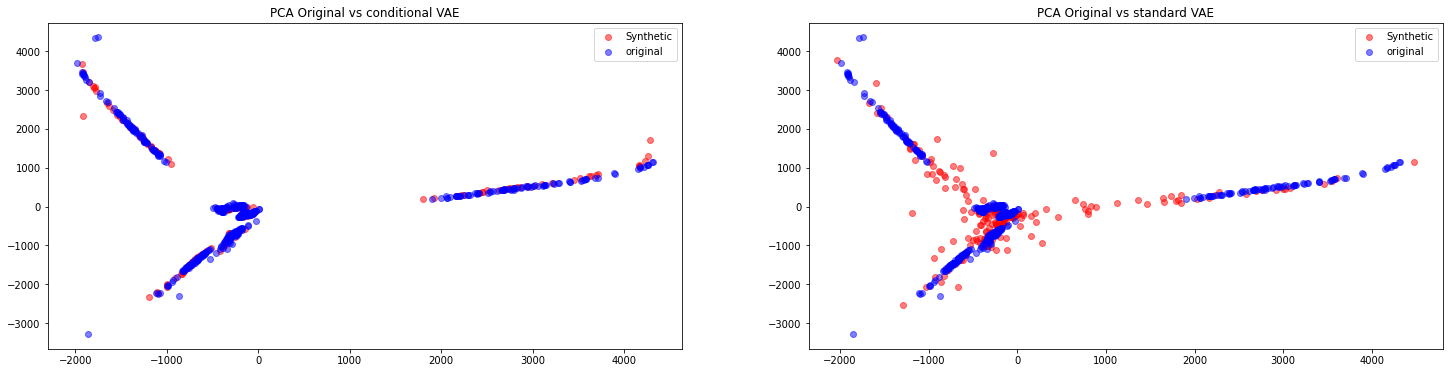

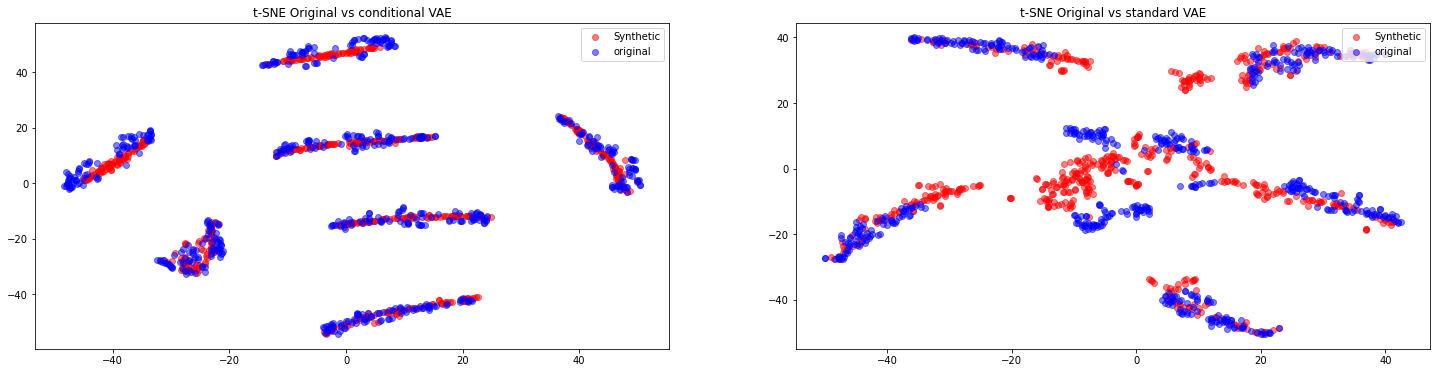

computing MMD
MMD between original data and 3939 samples with conditional model is: 4.515154526469479e-29
MMD between original data and 3939 samples with standard model is: 0.0


In [ ]:
results['sugar_fourier'] = train_and_analyse(X_sugar_train[:,:-1], c_sugar_train, 'sugar', model_types=['conditional', 'standard'],
                      validation_split=None, batch_size=100, 
                      num_samples=3, num_epochs=600, num_freq=100, 
                      latent_dims = 5, method = 'fourier', test_data=X_sugar_test[:,:-1])

In [ ]:
for model_type in ['conditional', 'standard']:
    M = results['sugar_fourier'][0][model_type][:,:].shape[0]
    Y = CEXP(results['sugar_fourier'][0][model_type][:,:])
    K = K_ID(X,Y)
    #gamma=1
    #K = K_SQR(gridwatch_data[:,:100], results['gridwatch'][0][method][:2000,:100])
    mmd = MMD_K(K, X_sugar_test[:,:].shape[0], M)
    print('MMD between original data and {} samples with {} basis is: {}'.format(M, model_type, mmd))


MMD between original data and 3939 samples with conditional basis is: 0.012874879983348415
MMD between original data and 3939 samples with standard basis is: 0.007007424284443796


#### LSTM classifier between synthetic and real?

In [18]:
# make train and test datasets
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
def LSTM_test(original, samples, model_types=['conditional', 'standard'], method ='matern', n_epochs=2, batch_size=50, state=42):

  lstm_histories = {}
  for model_type in model_types:
    combined_data = np.concatenate([original, samples[model_type][:original.shape[0],:]], axis=0)
    #combined_data = np.expand_dims(combined_data, axis=-1)
    labels = np.concatenate([np.ones((original.shape[0])), np.zeros((original.shape[0]))])
    labels = np.expand_dims(labels, axis=-1)
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc = enc.fit(labels)
    y_combined = enc.transform(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(combined_data, y_combined, test_size=0.5, random_state=state, stratify=y_combined)
    X_train = np.expand_dims(X_train, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

    model_lstm = keras.Sequential()
    model_lstm.add(
        keras.layers.Bidirectional(
          keras.layers.LSTM(
              units=20, 
              input_shape=[X_train.shape[1], X_train.shape[2]]
          )
        )
    )
    model_lstm.add(keras.layers.Dropout(rate=0.5))
    model_lstm.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

 
    history = model_lstm.fit(
          X_train, y_train,
          epochs=n_epochs,
          batch_size=batch_size,
          validation_data= (X_test, y_test),
          shuffle=True
      )
    lstm_histories[model_type] = history

  return lstm_histories
### should use same validation data set for each model.

In [ ]:
# classifier on synthetic data
LSTM_test(X_sugar[:,:-1], results['sugar_matern'][0], n_epochs=20, batch_size=150
          )

Epoch 1/20
13/13 [==============================] - 12s 649ms/step - loss: 0.7473 - acc: 0.4520 - val_loss: 0.7038 - val_acc: 0.4606
Epoch 2/20
13/13 [==============================] - 7s 569ms/step - loss: 0.7082 - acc: 0.5197 - val_loss: 0.6734 - val_acc: 0.6962
Epoch 3/20
13/13 [==============================] - 7s 560ms/step - loss: 0.6804 - acc: 0.5752 - val_loss: 0.6488 - val_acc: 0.7191
Epoch 4/20
13/13 [==============================] - 9s 742ms/step - loss: 0.6573 - acc: 0.6189 - val_loss: 0.6227 - val_acc: 0.6866
Epoch 5/20
13/13 [==============================] - 8s 590ms/step - loss: 0.6215 - acc: 0.6615 - val_loss: 0.5920 - val_acc: 0.6978
Epoch 6/20
13/13 [==============================] - 7s 582ms/step - loss: 0.5960 - acc: 0.6839 - val_loss: 0.5543 - val_acc: 0.7036
Epoch 7/20
13/13 [==============================] - 7s 569ms/step - loss: 0.5614 - acc: 0.7154 - val_loss: 0.5168 - val_acc: 0.7303
Epoch 8/20
13/13 [==============================] - 7s 564ms/step - loss: 0

{'conditional': <keras.callbacks.History at 0x7fdf3ae51810>,
 'standard': <keras.callbacks.History at 0x7fdf263aae10>}

In [ ]:
# classifier on synthetic data
LSTM_test(X_sugar[:,:-1], results['sugar_fourier'][0], n_epochs=20, batch_size=150
          )

Epoch 1/20
13/13 [==============================] - 12s 640ms/step - loss: 0.6883 - acc: 0.5629 - val_loss: 0.6289 - val_acc: 0.8897
Epoch 2/20
13/13 [==============================] - 7s 576ms/step - loss: 0.6355 - acc: 0.6498 - val_loss: 0.5881 - val_acc: 0.9803
Epoch 3/20
13/13 [==============================] - 7s 566ms/step - loss: 0.5950 - acc: 0.7170 - val_loss: 0.5475 - val_acc: 0.9643
Epoch 4/20
13/13 [==============================] - 7s 564ms/step - loss: 0.5530 - acc: 0.7612 - val_loss: 0.5027 - val_acc: 0.9792
Epoch 5/20
13/13 [==============================] - 7s 580ms/step - loss: 0.5056 - acc: 0.8230 - val_loss: 0.4509 - val_acc: 0.9813
Epoch 6/20
13/13 [==============================] - 7s 558ms/step - loss: 0.4503 - acc: 0.8705 - val_loss: 0.3868 - val_acc: 0.9787
Epoch 7/20
13/13 [==============================] - 7s 584ms/step - loss: 0.3903 - acc: 0.9003 - val_loss: 0.3108 - val_acc: 0.9931
Epoch 8/20
13/13 [==============================] - 10s 830ms/step - loss: 

{'conditional': <keras.callbacks.History at 0x7fdf18662ed0>,
 'standard': <keras.callbacks.History at 0x7fdf1539aed0>}

In [ ]:
# classifier on synthetic data
LSTM_test(X_sugar[:,:-1], results['sugar'][0], n_epochs=20, batch_size=150
          )

Epoch 1/20
13/13 [==============================] - 12s 636ms/step - loss: 0.7885 - acc: 0.5021 - val_loss: 0.6884 - val_acc: 0.5240
Epoch 2/20
13/13 [==============================] - 7s 563ms/step - loss: 0.7365 - acc: 0.5096 - val_loss: 0.6835 - val_acc: 0.5016
Epoch 3/20
13/13 [==============================] - 7s 549ms/step - loss: 0.7309 - acc: 0.5155 - val_loss: 0.6756 - val_acc: 0.6530
Epoch 4/20
13/13 [==============================] - 7s 561ms/step - loss: 0.7125 - acc: 0.5272 - val_loss: 0.6729 - val_acc: 0.6636
Epoch 5/20
13/13 [==============================] - 7s 553ms/step - loss: 0.7132 - acc: 0.5272 - val_loss: 0.6683 - val_acc: 0.6604
Epoch 6/20
13/13 [==============================] - 7s 571ms/step - loss: 0.6893 - acc: 0.5501 - val_loss: 0.6613 - val_acc: 0.6562
Epoch 7/20
13/13 [==============================] - 7s 557ms/step - loss: 0.6945 - acc: 0.5629 - val_loss: 0.6503 - val_acc: 0.6599
Epoch 8/20
13/13 [==============================] - 7s 562ms/step - loss: 0

{'conditional': <keras.callbacks.History at 0x7fdf083a2e10>,
 'standard': <keras.callbacks.History at 0x7fdf01abe7d0>}

### Everything on Gridwatch Again

In [ ]:
X_grid_train, X_grid_test, c_grid_train, c_grid_test = train_test_split(
    X_grid, np.transpose(c_grid), test_size=0.3, random_state=42, stratify=np.transpose(c_grid))

Performing training and analysis on grid
Epoch 1/600
8/8 [==============================] - 2s 6ms/step - loss: 440.1328
Epoch 2/600
8/8 [==============================] - 0s 8ms/step - loss: 124.7509
Epoch 3/600
8/8 [==============================] - 0s 5ms/step - loss: 66.4571
Epoch 4/600
8/8 [==============================] - 0s 9ms/step - loss: 49.8808
Epoch 5/600
8/8 [==============================] - 0s 5ms/step - loss: 40.3095
Epoch 6/600
8/8 [==============================] - 0s 7ms/step - loss: 41.0772
Epoch 7/600
8/8 [==============================] - 0s 6ms/step - loss: 33.4049
Epoch 8/600
8/8 [==============================] - 0s 5ms/step - loss: 31.7579
Epoch 9/600
8/8 [==============================] - 0s 4ms/step - loss: 35.8746
Epoch 10/600
8/8 [==============================] - 0s 5ms/step - loss: 35.5097
Epoch 11/600
8/8 [==============================] - 0s 8ms/step - loss: 43.3350
Epoch 12/600
8/8 [==============================] - 0s 8ms/step - loss: 28.6480
Epoch 

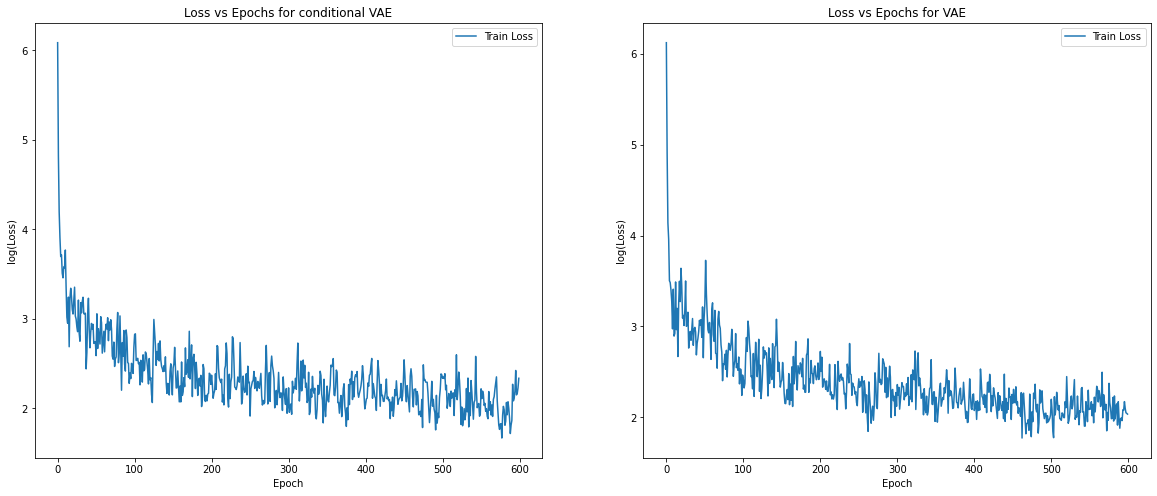

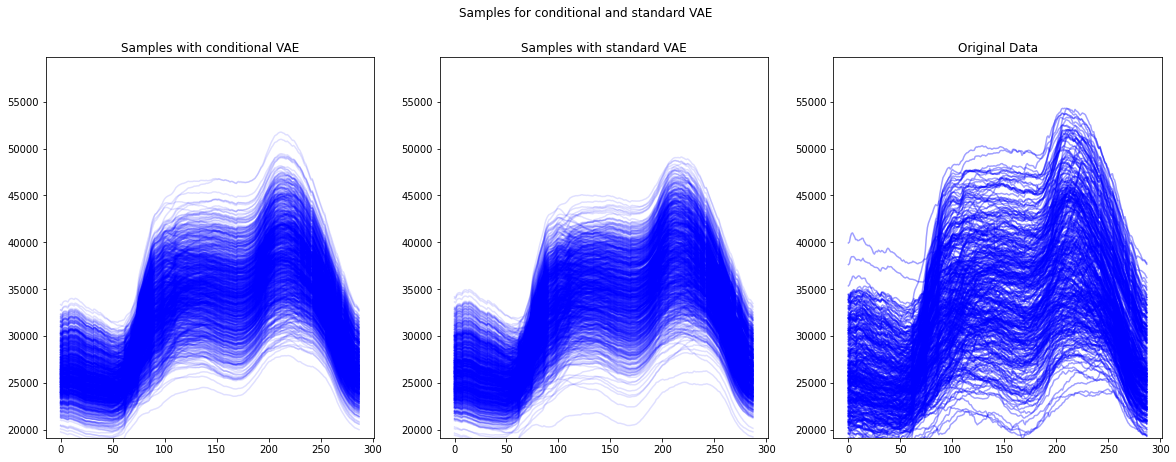

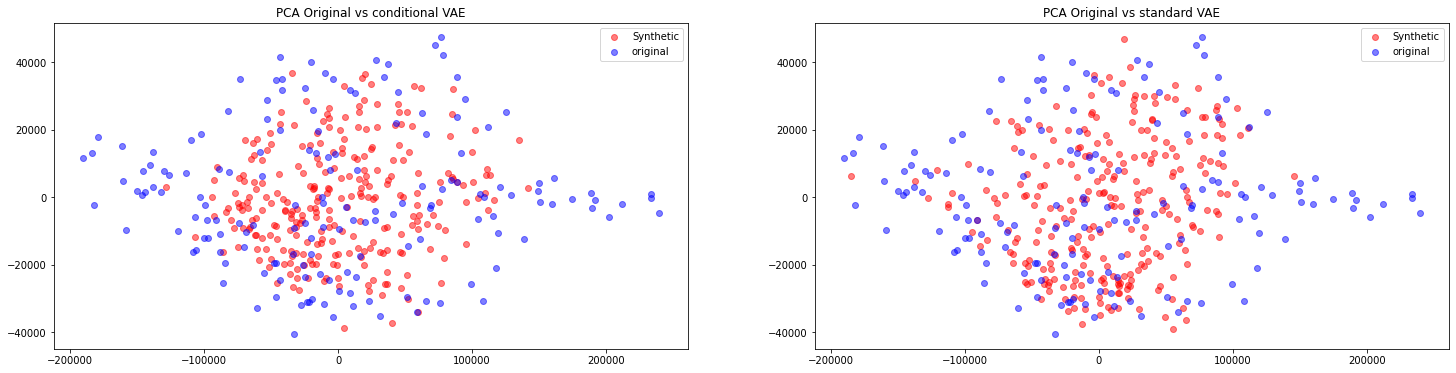

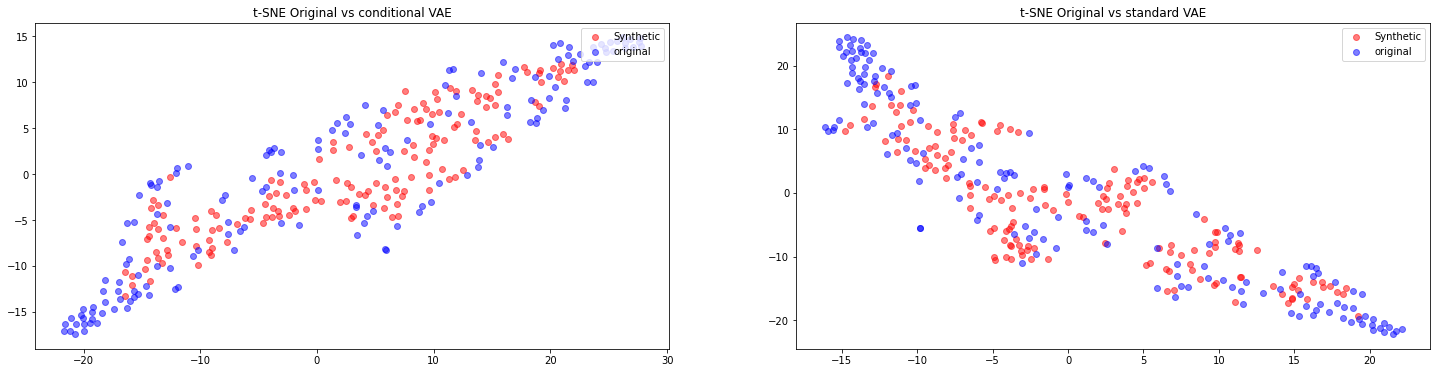

computing MMD
MMD between original data and 1116 samples with conditional model is: 0.0
MMD between original data and 1116 samples with standard model is: 0.0


In [ ]:
#results = {}

results['grid_fpca'] = train_and_analyse(X_grid_train[:,:], c_grid_train, 'grid', model_types=['conditional', 'standard'],
                      validation_split=None, batch_size=50, 
                      num_samples=3, num_epochs=600, num_freq=100, 
                      latent_dims = 5, method = 'fpca', test_data=X_grid_test)

In [ ]:
X = CEXP(X_grid)
for model_type in ['conditional', 'standard']:
    N = X_grid[:,:-1].shape[0]
    M = results['grid_fpca'][0][model_type][:N,:].shape[0]
    Y = CEXP(results['grid_fpca'][0][model_type][:N,:])
    K = K_ID(X,Y)
    #gamma=1
    #K = K_SQR(gridwatch_data[:,:100], results['gridwatch'][0][method][:2000,:100])
    mmd = MMD_K(K, N, M)
    print('MMD between original data and {} samples with {} basis is: {}'.format(M, model_type, mmd))


MMD between original data and 532 samples with conditional basis is: 5.1964696157299086e-163
MMD between original data and 532 samples with standard basis is: 3.798911336304166e-93


Performing training and analysis on grid
Epoch 1/600
8/8 [==============================] - 1s 5ms/step - loss: 18.3974
Epoch 2/600
8/8 [==============================] - 0s 5ms/step - loss: 15.6780
Epoch 3/600
8/8 [==============================] - 0s 5ms/step - loss: 11.1401
Epoch 4/600
8/8 [==============================] - 0s 4ms/step - loss: 5.3225
Epoch 5/600
8/8 [==============================] - 0s 5ms/step - loss: 2.4023
Epoch 6/600
8/8 [==============================] - 0s 5ms/step - loss: 1.9114
Epoch 7/600
8/8 [==============================] - 0s 5ms/step - loss: 1.2389
Epoch 8/600
8/8 [==============================] - 0s 6ms/step - loss: 0.9396
Epoch 9/600
8/8 [==============================] - 0s 5ms/step - loss: 0.7646
Epoch 10/600
8/8 [==============================] - 0s 4ms/step - loss: 0.7168
Epoch 11/600
8/8 [==============================] - 0s 5ms/step - loss: 0.6259
Epoch 12/600
8/8 [==============================] - 0s 4ms/step - loss: 0.5262
Epoch 13/600
8/8 

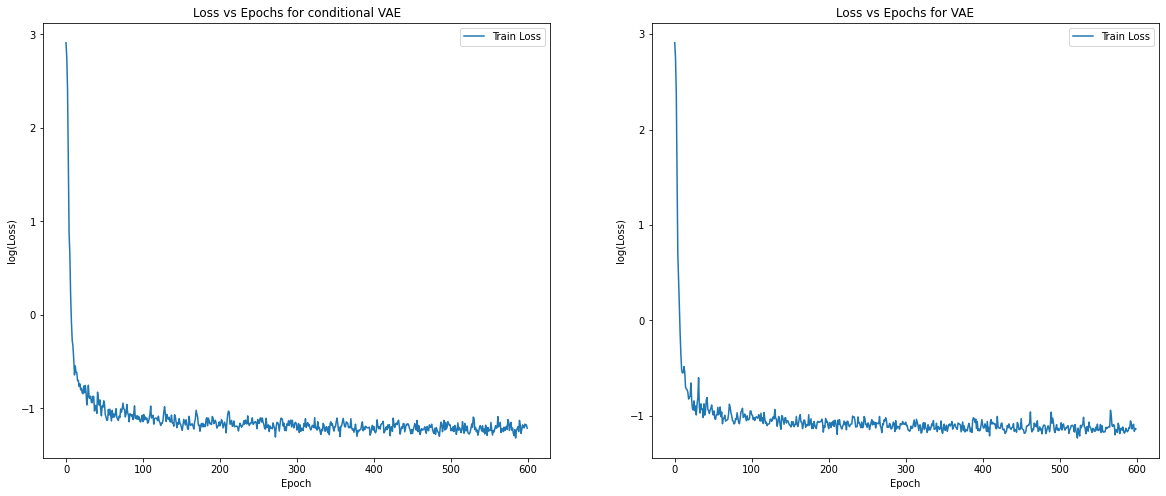

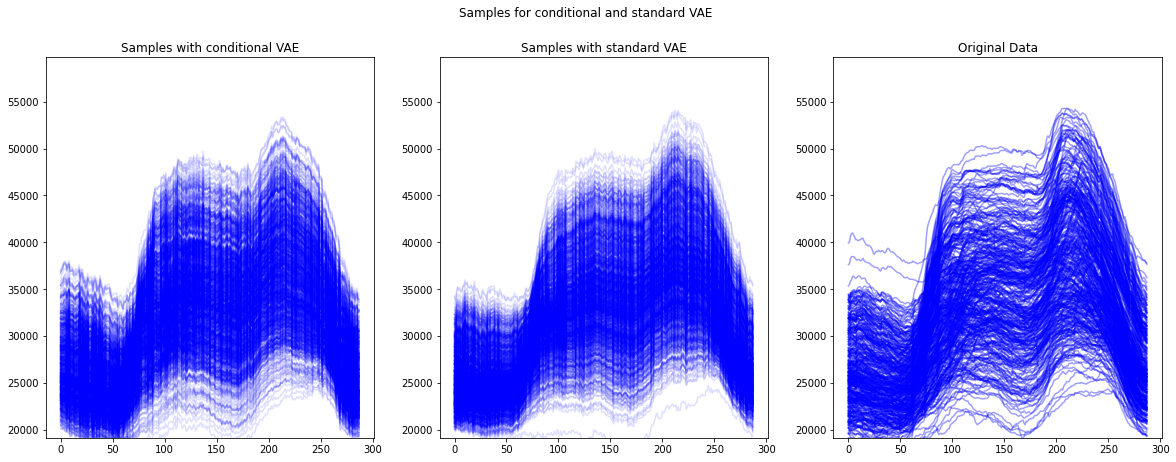

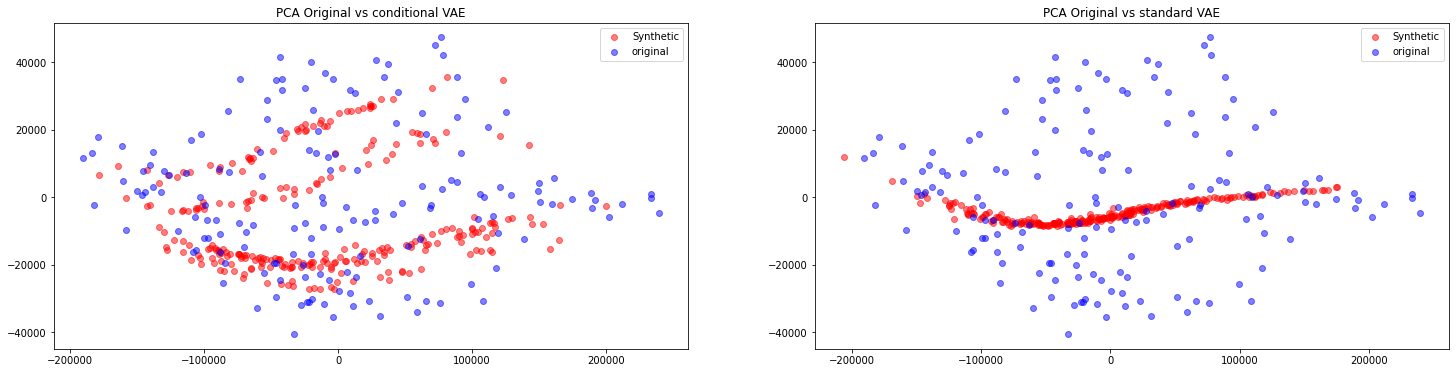

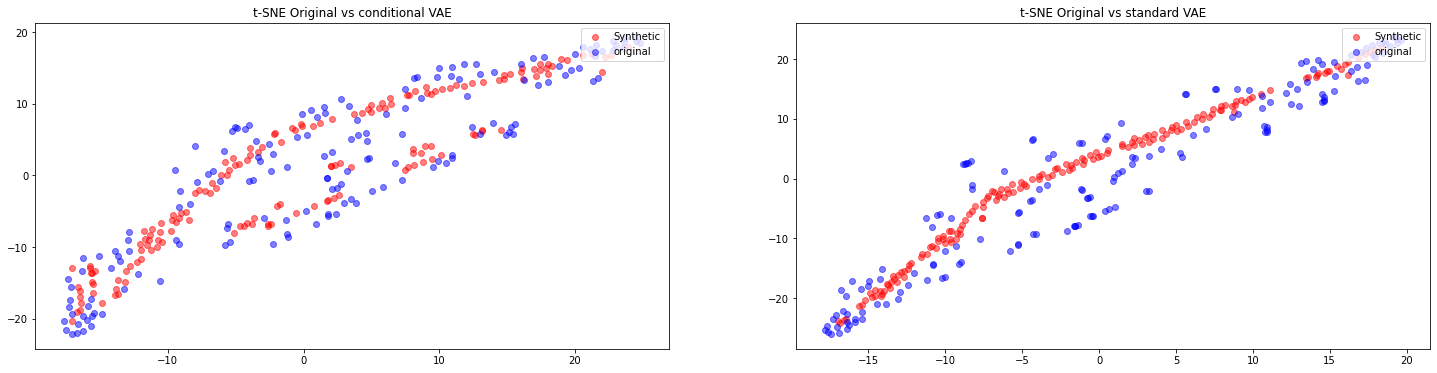

computing MMD
MMD between original data and 1116 samples with conditional model is: 0.0
MMD between original data and 1116 samples with standard model is: 0.0


In [ ]:

results['grid_matern'] = train_and_analyse(X_grid_train[:,:], c_grid_train, 'grid', model_types=['conditional', 'standard'],
                      validation_split=None, batch_size=50, 
                      num_samples=3, num_epochs=600, num_freq=100, 
                      latent_dims = 5, method = 'matern', test_data=X_grid_test)

In [ ]:

for model_type in ['conditional', 'standard']:
    N = X_grid[:,:-1].shape[0]
    M = results['grid_matern'][0][model_type][:N,:].shape[0]
    Y = CEXP(results['grid_matern'][0][model_type][:N,:])
    K = K_ID(X,Y)
    #gamma=1
    #K = K_SQR(gridwatch_data[:,:100], results['gridwatch'][0][method][:2000,:100])
    mmd = MMD_K(K, N, M)
    print('MMD between original data and {} samples with {} basis is: {}'.format(M, model_type, mmd))


MMD between original data and 532 samples with conditional basis is: 8.168883198971246e-198
MMD between original data and 532 samples with standard basis is: 7.739031507874555e-73


Performing training and analysis on grid
Epoch 1/600
8/8 [==============================] - 2s 10ms/step - loss: 51.5302
Epoch 2/600
8/8 [==============================] - 0s 5ms/step - loss: 41.5412
Epoch 3/600
8/8 [==============================] - 0s 5ms/step - loss: 25.0315
Epoch 4/600
8/8 [==============================] - 0s 6ms/step - loss: 8.7373
Epoch 5/600
8/8 [==============================] - 0s 4ms/step - loss: 4.5504
Epoch 6/600
8/8 [==============================] - 0s 7ms/step - loss: 3.5197
Epoch 7/600
8/8 [==============================] - 0s 4ms/step - loss: 2.4833
Epoch 8/600
8/8 [==============================] - 0s 5ms/step - loss: 2.0175
Epoch 9/600
8/8 [==============================] - 0s 5ms/step - loss: 1.4477
Epoch 10/600
8/8 [==============================] - 0s 7ms/step - loss: 1.2821
Epoch 11/600
8/8 [==============================] - 0s 9ms/step - loss: 1.1762
Epoch 12/600
8/8 [==============================] - 0s 7ms/step - loss: 1.2827
Epoch 13/600
8/8

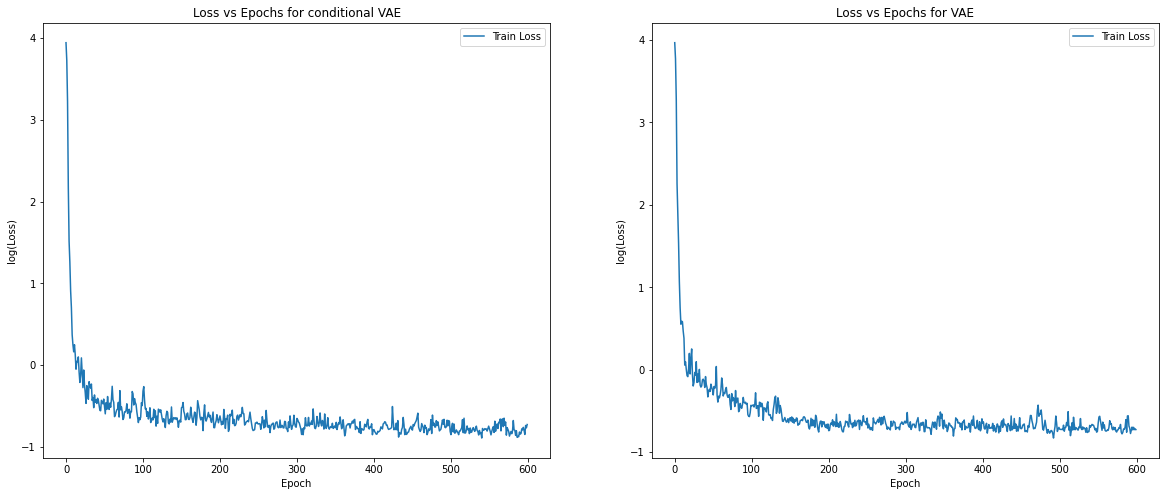

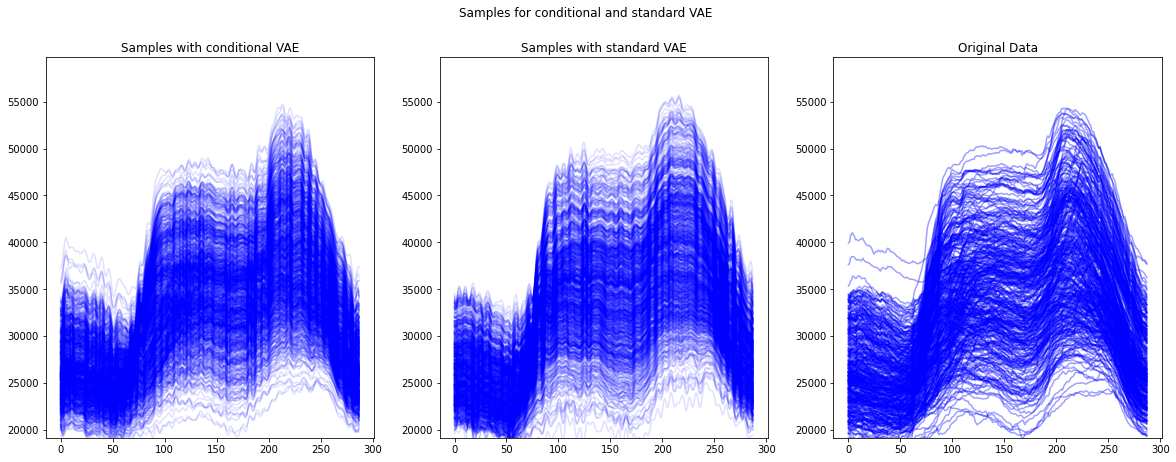

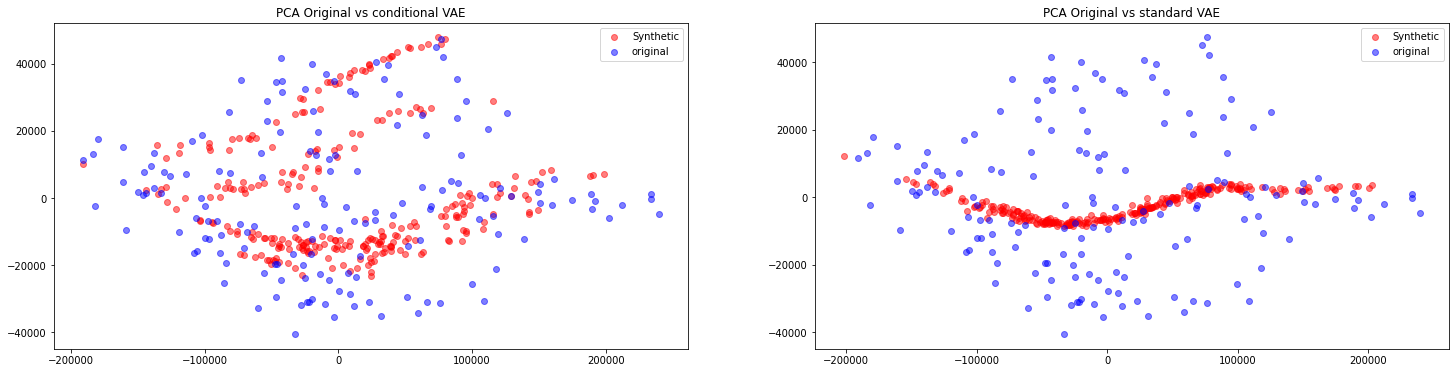

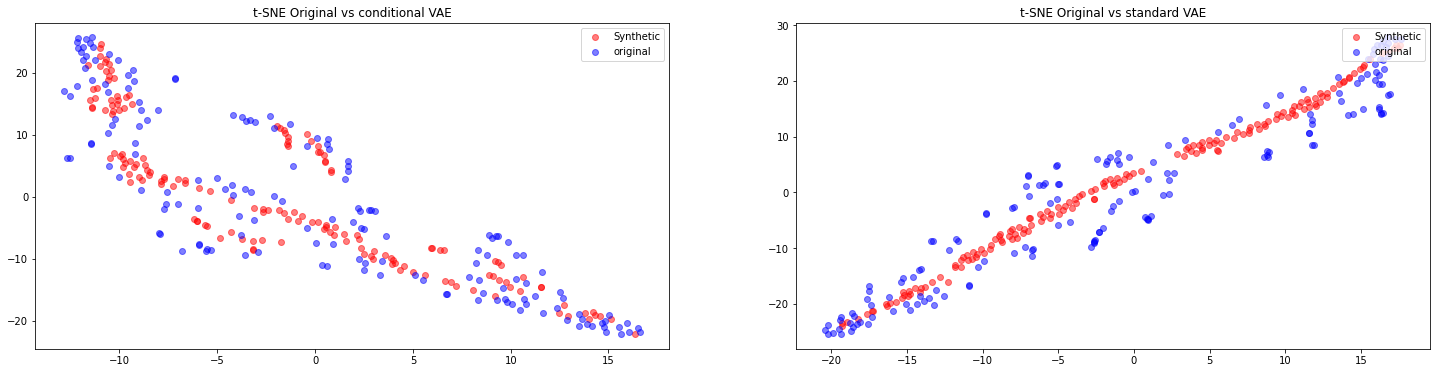

computing MMD
MMD between original data and 1116 samples with conditional model is: 0.0
MMD between original data and 1116 samples with standard model is: 0.0


In [ ]:
results= {}
results['grid_fourier'] = train_and_analyse(X_grid_train[:,:], c_grid_train, 'grid', model_types=['conditional', 'standard'],
                      validation_split=None, batch_size=50, 
                      num_samples=3, num_epochs=600, num_freq=50, 
                      latent_dims = 5, method = 'fourier', test_data=X_grid_test)

In [ ]:
X = CEXP(X_grid)
for model_type in ['conditional', 'standard']:
    N = X_grid[:,:-1].shape[0]
    M = results['grid_fourier'][0][model_type][:,:].shape[0]
    Y = CEXP(results['grid_fourier'][0][model_type][:,:])
    K = K_ID(X,Y)
    #gamma=1
    #K = K_SQR(gridwatch_data[:,:100], results['gridwatch'][0][method][:2000,:100])
    mmd = MMD_K(K, N, M)
    print('MMD between original data and {} samples with {} basis is: {}'.format(M, model_type, mmd))


MMD between original data and 1116 samples with conditional basis is: 5.623904871329649e-29
MMD between original data and 1116 samples with standard basis is: 2.0703042560888092e-35


In [ ]:
conditional_accuracies = []
standard_accuracies = []
for i in range(6):
  histories = LSTM_test(X_grid[:,:], results['grid_fourier'][0], n_epochs=20, batch_size=150, state=i
          )
  conditional_accuracies.append(histories['conditional'].history['val_acc'][-1])
  standard_accuracies.append(histories['standard'].history['val_acc'][-1])

Epoch 1/20
4/4 [==============================] - 11s 857ms/step - loss: 0.7349 - acc: 0.5132 - val_loss: 0.7010 - val_acc: 0.5000
Epoch 2/20
4/4 [==============================] - 2s 459ms/step - loss: 0.7169 - acc: 0.5226 - val_loss: 0.6984 - val_acc: 0.5000
Epoch 3/20
4/4 [==============================] - 1s 263ms/step - loss: 0.7346 - acc: 0.4906 - val_loss: 0.6966 - val_acc: 0.5000
Epoch 4/20
4/4 [==============================] - 1s 268ms/step - loss: 0.7317 - acc: 0.4831 - val_loss: 0.6952 - val_acc: 0.5000
Epoch 5/20
4/4 [==============================] - 1s 264ms/step - loss: 0.7385 - acc: 0.4643 - val_loss: 0.6943 - val_acc: 0.5000
Epoch 6/20
4/4 [==============================] - 1s 273ms/step - loss: 0.7058 - acc: 0.5470 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 7/20
4/4 [==============================] - 1s 266ms/step - loss: 0.7356 - acc: 0.4906 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 8/20
4/4 [==============================] - 1s 270ms/step - loss: 0.7300 - acc: 0.4

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f4d76013d40>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


Epoch 1/20
4/4 [==============================] - 10s 967ms/step - loss: 0.7476 - acc: 0.5282 - val_loss: 0.6947 - val_acc: 0.5000
Epoch 2/20
4/4 [==============================] - 2s 451ms/step - loss: 0.7759 - acc: 0.4662 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 3/20
4/4 [==============================] - 2s 489ms/step - loss: 0.7394 - acc: 0.5075 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/20
4/4 [==============================] - 2s 440ms/step - loss: 0.7497 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/20
4/4 [==============================] - 2s 649ms/step - loss: 0.7363 - acc: 0.5113 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/20
4/4 [==============================] - 1s 275ms/step - loss: 0.7567 - acc: 0.4887 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/20
4/4 [==============================] - 1s 277ms/step - loss: 0.7531 - acc: 0.5301 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/20
4/4 [==============================] - 1s 272ms/step - loss: 0.7524 - acc: 0.4

KeyboardInterrupt: ignored

In [ ]:
# classifier on synthetic data
LSTM_test(X_grid[:,:], results['grid_fourier'][0], n_epochs=20, batch_size=150, state=2
          )

Epoch 1/20
4/4 [==============================] - 6s 564ms/step - loss: 0.7356 - acc: 0.4831 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 2/20
4/4 [==============================] - 1s 296ms/step - loss: 0.7385 - acc: 0.4831 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 3/20
4/4 [==============================] - 1s 335ms/step - loss: 0.7151 - acc: 0.4962 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 4/20
4/4 [==============================] - 2s 417ms/step - loss: 0.7192 - acc: 0.5150 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/20
4/4 [==============================] - 1s 295ms/step - loss: 0.7280 - acc: 0.4737 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/20
4/4 [==============================] - 1s 305ms/step - loss: 0.7119 - acc: 0.5038 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/20
4/4 [==============================] - 1s 302ms/step - loss: 0.7242 - acc: 0.4906 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/20
4/4 [==============================] - 1s 290ms/step - loss: 0.7215 - acc: 0.49

{'conditional': <keras.callbacks.History at 0x7fdf3a5f3950>,
 'standard': <keras.callbacks.History at 0x7fdf1e338790>}

In [ ]:
LSTM_test(X_grid[:,:], results['grid_matern'][0], n_epochs=20, batch_size=150, state= 2
          )

Epoch 1/20
4/4 [==============================] - 11s 988ms/step - loss: 0.7875 - acc: 0.5056 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 2/20
4/4 [==============================] - 2s 463ms/step - loss: 0.7940 - acc: 0.4925 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 3/20
4/4 [==============================] - 2s 462ms/step - loss: 0.8130 - acc: 0.4756 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 4/20
4/4 [==============================] - 2s 493ms/step - loss: 0.7699 - acc: 0.5113 - val_loss: 0.6936 - val_acc: 0.5000
Epoch 5/20
4/4 [==============================] - 2s 452ms/step - loss: 0.7778 - acc: 0.5075 - val_loss: 0.6935 - val_acc: 0.5000
Epoch 6/20
4/4 [==============================] - 2s 468ms/step - loss: 0.7714 - acc: 0.5056 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 7/20
4/4 [==============================] - 1s 305ms/step - loss: 0.7975 - acc: 0.5038 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 8/20
4/4 [==============================] - 1s 298ms/step - loss: 0.7362 - acc: 0.5

{'conditional': <keras.callbacks.History at 0x7fdf39a050d0>,
 'standard': <keras.callbacks.History at 0x7fdf1e7b8590>}

In [ ]:
LSTM_test(X_grid[:,:], results['grid_fpca'][0], n_epochs=20, batch_size=150, state = 2
          )

Epoch 1/20
4/4 [==============================] - 7s 585ms/step - loss: 0.7849 - acc: 0.5169 - val_loss: 0.6943 - val_acc: 0.5000
Epoch 2/20
4/4 [==============================] - 1s 307ms/step - loss: 0.7913 - acc: 0.5207 - val_loss: 0.6941 - val_acc: 0.5000
Epoch 3/20
4/4 [==============================] - 1s 314ms/step - loss: 0.7689 - acc: 0.5094 - val_loss: 0.6937 - val_acc: 0.5000
Epoch 4/20
4/4 [==============================] - 1s 307ms/step - loss: 0.7932 - acc: 0.4774 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 5/20
4/4 [==============================] - 1s 327ms/step - loss: 0.8116 - acc: 0.4455 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 6/20
4/4 [==============================] - 1s 328ms/step - loss: 0.7687 - acc: 0.5132 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/20
4/4 [==============================] - 1s 306ms/step - loss: 0.7566 - acc: 0.5094 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/20
4/4 [==============================] - 1s 315ms/step - loss: 0.7864 - acc: 0.48

{'conditional': <keras.callbacks.History at 0x7fdf07e34910>,
 'standard': <keras.callbacks.History at 0x7fdf3ad35050>}

#### Some other plots of multi modal and VAE samples.


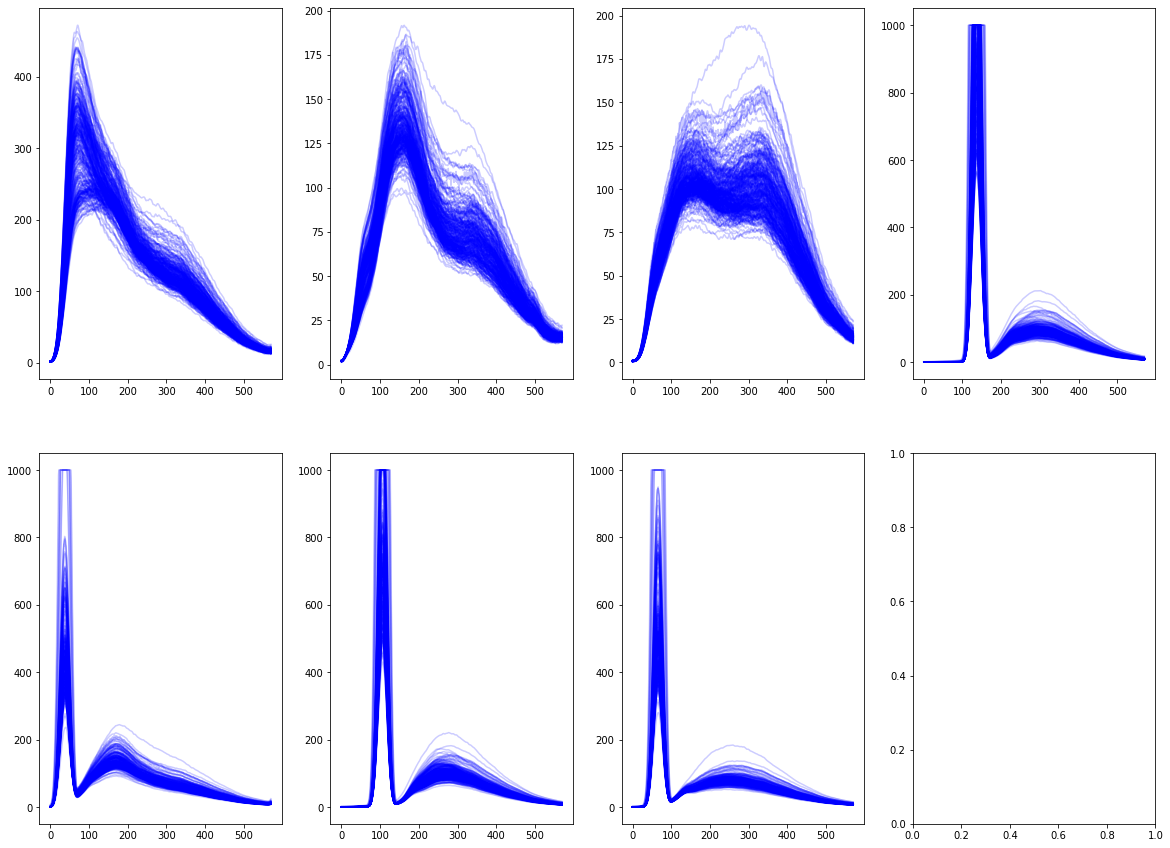

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(20, 15))

for i, ax in enumerate(fig.axes):
  if i<7:
    ax.plot( np.transpose(data[:,1:,i]), color='blue', alpha=0.2)
plt.show()

In [ ]:
indeces = np.random.randint(0,stacked_X.shape[0],20)
vae_output = Spectra_vae([full_spectra, labels])

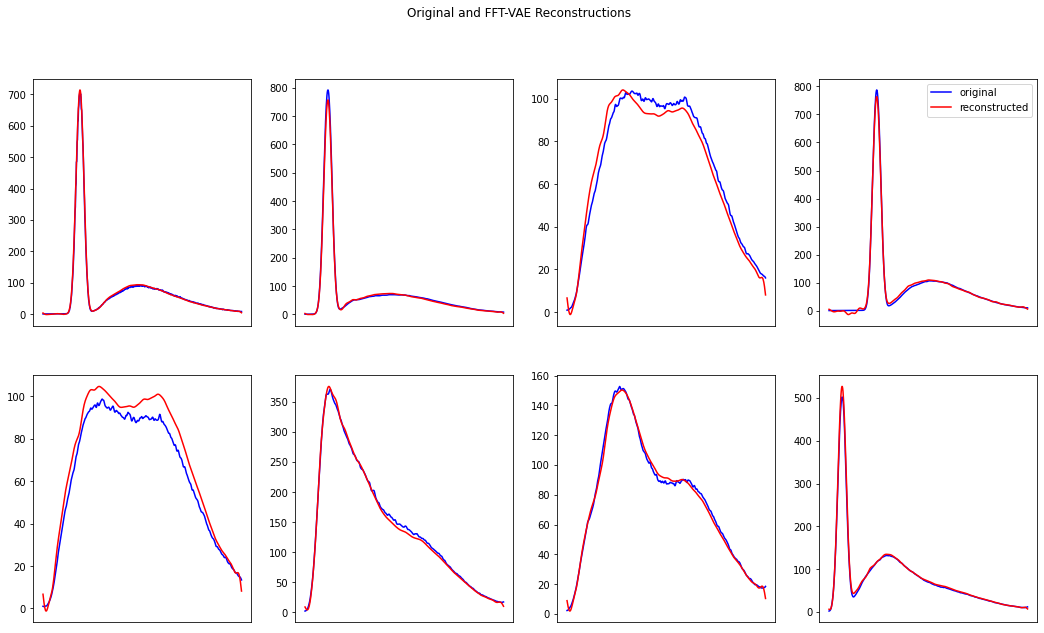

In [ ]:
reconstructed = invert_fourier(vae_output, original_length_of_FFT=len(fourier_spectra[i,:]), normalise_fourier=1000, normalise_path=1)
plot_vae_reconstructions(reconstructed[indeces,:], stacked_X[indeces,:])

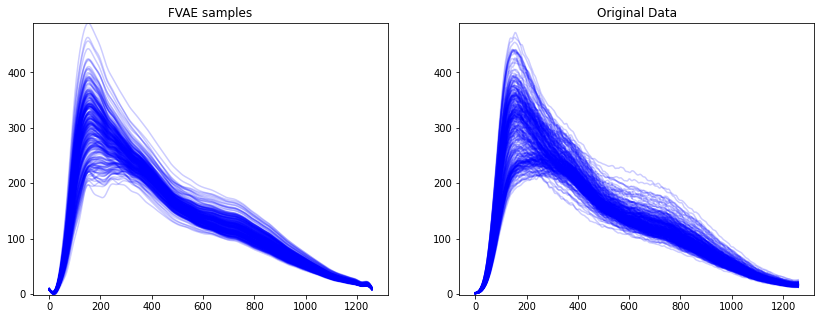

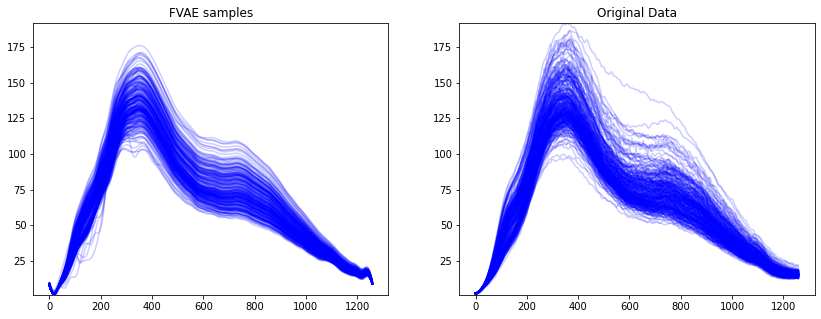

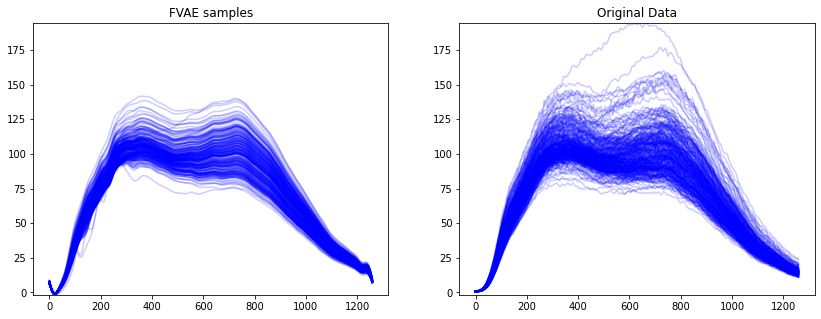

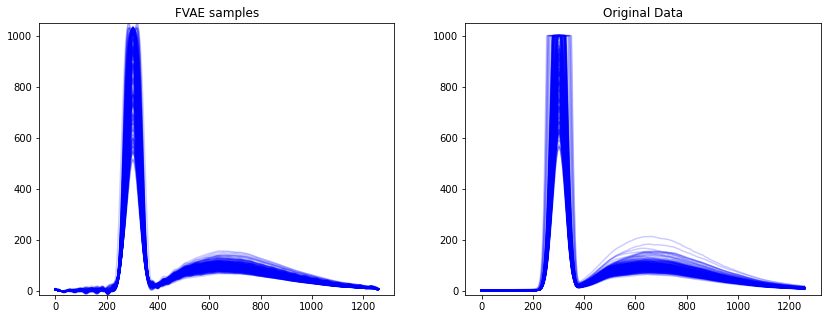

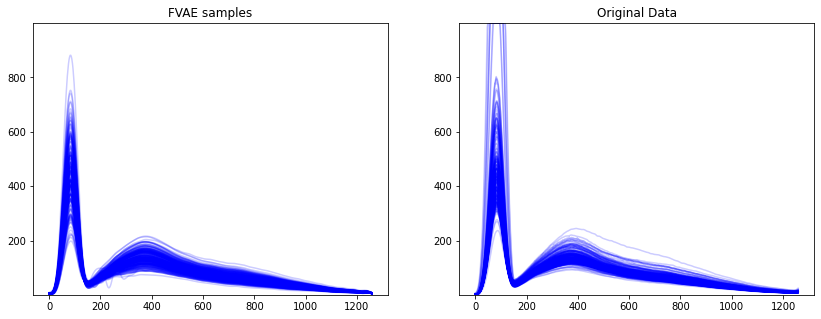

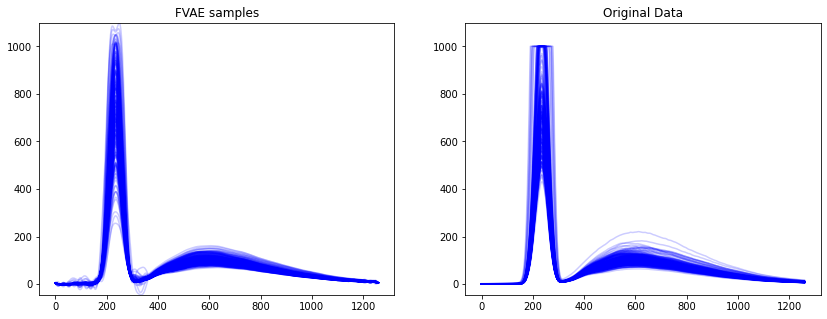

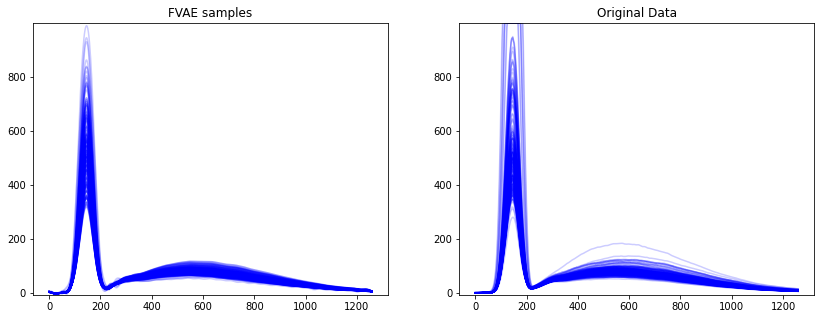

In [ ]:
for i in range(7):
  label=i
  plot_CVAE_samples_v_original(data[:,1:,label], decoder=Spectra_vae.decoder, prior=None, num_samples=268, label=label, original_length_of_FFT=len(fourier_spectra[0,:]), latent_size=10, tf_prob=False, normalise_fourier=1000, normalise_path=1)

### CVAE for function on function regression or multivariate data generation

Text(0, 0.5, 'Emission')

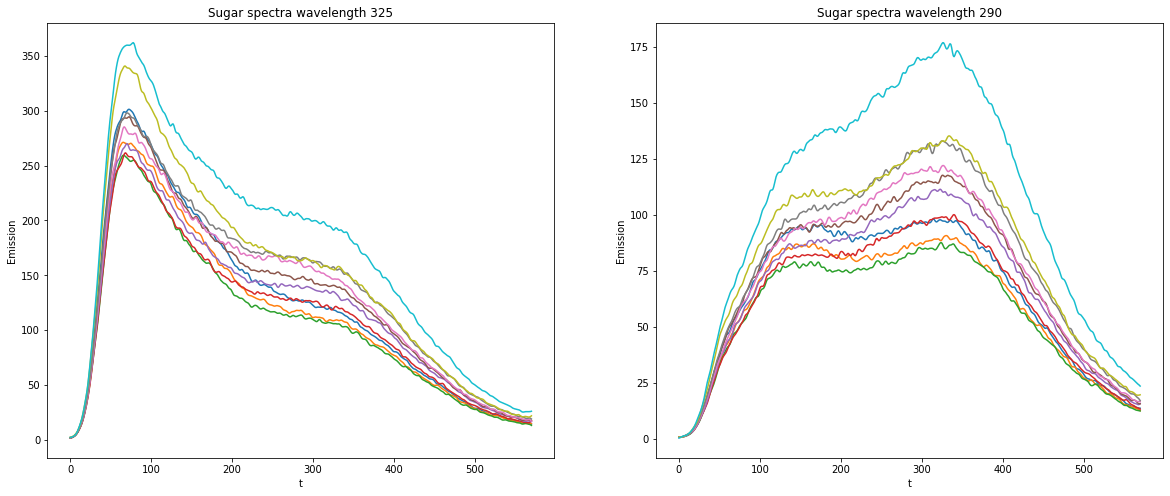

In [120]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(20,8))

ax0.plot(np.transpose(sugar_spectra[:10,:,0]))#, color='blue', alpha=0.2)
ax0.set_title('Sugar spectra wavelength 325')
ax0.set_xlabel('t')
ax0.set_ylabel('Emission')
ax1.plot(np.transpose(sugar_spectra[:10,:,2]))#, color='blue', alpha=0.2)
ax1.set_title('Sugar spectra wavelength 290')
ax1.set_xlabel('t')
ax1.set_ylabel('Emission')

In [19]:
output = sugar_spectra[:,:-1,0]
condition = sugar_spectra[:,:-1,2]

In [20]:
#output, for_inversion_output, input_shape_output = transform_data(output, 'fpca', num_freq=30, mother='db2')
c_condition, _, _ = transform_data(condition-np.mean(condition, axis=0), 'fpca', num_freq=5, mother='db2')

In [21]:
all_parts_bivariate = {}
all_parts_bivariate['condition']  = train_models(condition, method='fpca', latent_dims=5, intermediate_dims=100, 
                 lr=0.005, num_epochs=500, batch_size=25, num_freq=100, 
                 max_after_scaling = 100, validation_split = None)
# model, hist, for_inversion, scaler
all_parts_bivariate['output'] = train_conditional_models(output, c_condition, method='fpca', latent_dims=5, 
                             intermediate_dims=100, lr=0.005, num_epochs=500, batch_size=25, 
                             num_freq=100, max_after_scaling = 100, validation_split = None)

Epoch 1/500
11/11 [==============================] - 2s 3ms/step - loss: 112.3111
Epoch 2/500
11/11 [==============================] - 0s 3ms/step - loss: 47.4046
Epoch 3/500
11/11 [==============================] - 0s 4ms/step - loss: 22.9941
Epoch 4/500
11/11 [==============================] - 0s 3ms/step - loss: 35.6611
Epoch 5/500
11/11 [==============================] - 0s 4ms/step - loss: 43.9433
Epoch 6/500
11/11 [==============================] - 0s 4ms/step - loss: 23.5449
Epoch 7/500
11/11 [==============================] - 0s 4ms/step - loss: 26.0274
Epoch 8/500
11/11 [==============================] - 0s 4ms/step - loss: 25.9184
Epoch 9/500
11/11 [==============================] - 0s 4ms/step - loss: 20.8140
Epoch 10/500
11/11 [==============================] - 0s 4ms/step - loss: 36.5918
Epoch 11/500
11/11 [==============================] - 0s 4ms/step - loss: 30.3103
Epoch 12/500
11/11 [==============================] - 0s 4ms/step - loss: 31.3990
Epoch 13/500
11/11 [====

In [22]:
def sample_plot_multi(upsampled_labels, models, inversions, scalers, model_types, original, method='matern', latent_dims = 10):

  prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dims), scale=1), reinterpreted_batch_ndims=1)
  all_samples = {}
  num_samples = upsampled_labels.shape[0]
  for model_type in model_types:
    latent_samples = prior.sample(num_samples)
    model = models
    for_inversion = inversions
    scaler = scalers

    #decode with decoder
    if model_type == 'conditional':
      decoded_samples = model.decoder(tf.concat([latent_samples, upsampled_labels], axis=1))
    else:
      decoded_samples = model.decoder(latent_samples)

    decoded_samples_rescaled = invert_scaling(decoded_samples, scaler)
    #invert transform
    if method == 'dwt':
      decoded_samples_rescaled = decoded_samples_rescaled.numpy()
    final_samples = invert_data(decoded_samples_rescaled, method, for_inversion)
    if method == 'fpca': # for fpca need to add mean back on
      final_samples = final_samples + np.mean(original, axis=0)
    if method == 'cwt':
      ## potntially need to also center first
      final_samples = final_samples
    all_samples[model_type] = final_samples

  fig, axs = plt.subplots(1, len(model_types)+1 , figsize=(20, 7))
  max = np.max(original)
  min = np.min(original)
  for i, ax in enumerate(fig.axes):
    if i>=len(model_types):
      ax.plot(np.transpose(original), color='blue', alpha=20*7/original.shape[0], label='true data')
      ax.set_title('Original Data')
      ax.set_ylim([1.1*min,1.1*max])
    else:
      ax.plot(np.transpose(all_samples[model_types[i]]), color='blue', alpha=20*7/num_samples, label=model_types[i])
      ax.set_title('Samples with {} VAE'.format(model_types[i]))
      ax.set_ylim([1.1*min,1.1*max])
    
  fig.suptitle('Samples for conditional and standard VAE')
  plt.show()
  
  return all_samples

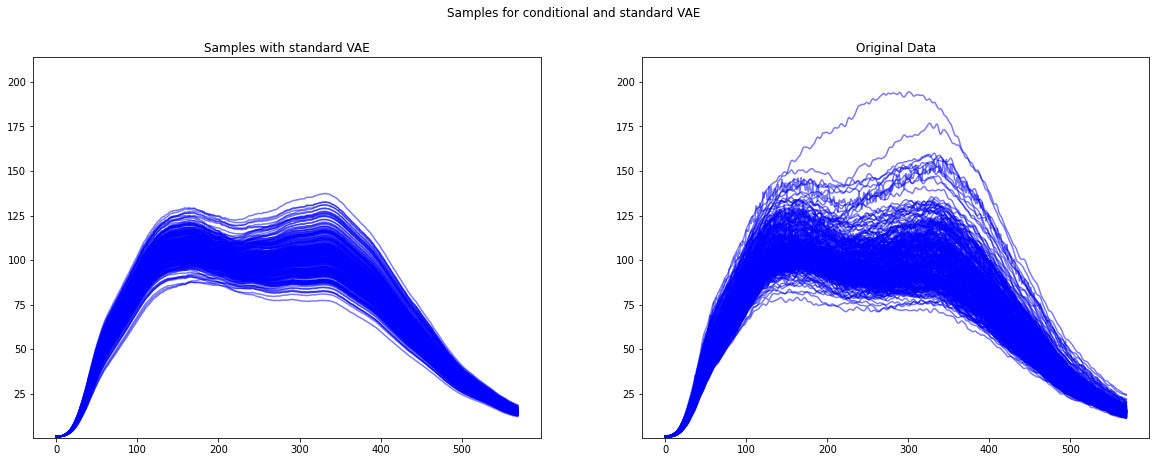

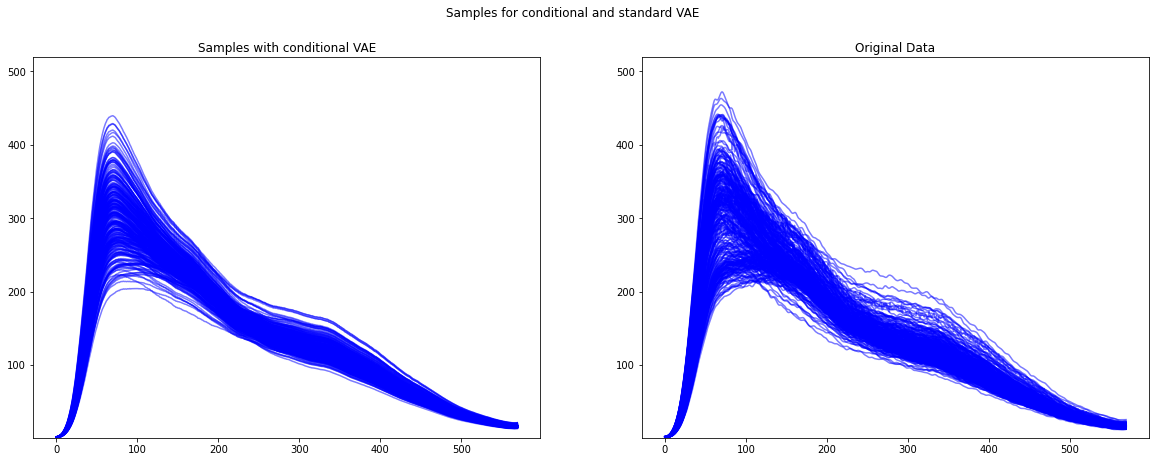

In [23]:
condition_samples = sample_plot_multi(np.ones((268,)), all_parts_bivariate['condition'][0], all_parts_bivariate['condition'][2], all_parts_bivariate['condition'][3], model_types=['standard'], original=condition, method='fpca', latent_dims = 5)

# labels are transofrm of x1 samples

upsampled_labels = all_parts_bivariate['condition'][2].transform(condition_samples['standard']-np.mean(condition_samples['standard'],axis=0))

output_samples = sample_plot_multi(upsampled_labels, all_parts_bivariate['output'][0], all_parts_bivariate['output'][2], all_parts_bivariate['output'][3], model_types=['conditional'], original=output, method='fpca', latent_dims = 5)


In [24]:
# to compare use t-SNE of concatenated functions?

multi_concat = np.concatenate([condition_samples['standard'], output_samples['conditional']], axis=1)
original_concat = np.concatenate([condition, output], axis=1)

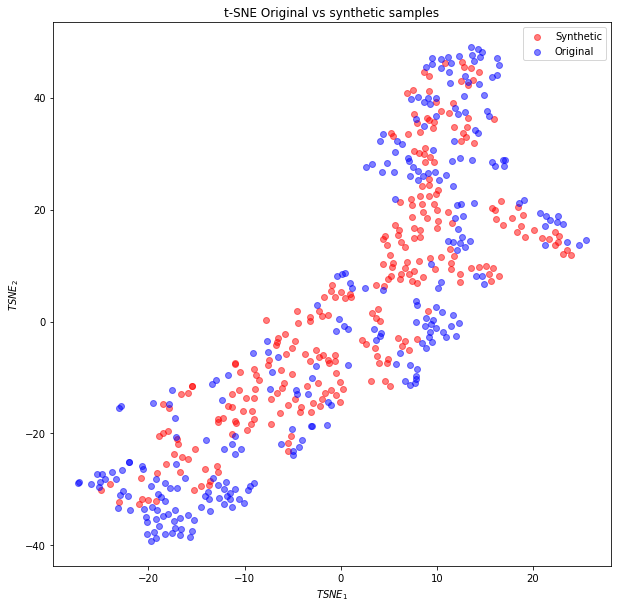

In [25]:
#TSNE_vis(multi_concat, original_concat, ['fpca'])
plt.figure(figsize=(10,10))
num_original = original_concat.shape[0]

TSNE_ = TSNE(n_components=2)
projected = TSNE_.fit_transform(np.concatenate([original_concat, multi_concat[:num_original,:]], axis=0))
plt.scatter(projected[num_original:,0], projected[num_original:,1], color='red', label='Synthetic', alpha=0.5)
plt.scatter(projected[:num_original,0],projected[:num_original,1], color='blue', label = 'Original', alpha=0.5)
plt.title('t-SNE Original vs synthetic samples')
plt.legend(loc='upper right')
plt.xlabel(r'$TSNE_1$')
plt.ylabel(r'$TSNE_2$')
plt.show() 

In [35]:


synth_multi = np.stack([condition_samples['standard'], output_samples['conditional']],axis = 2)
original_multi = np.stack([condition, output], axis=2)

combined_data = np.concatenate([original_multi, synth_multi[:original_multi.shape[0],:]], axis=0)
#combined_data = np.expand_dims(combined_data, axis=-1)
labels = np.concatenate([np.ones((original_multi.shape[0])), np.zeros((original_multi.shape[0]))])
labels = np.expand_dims(labels, axis=-1)
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(labels)
y_combined = enc.transform(labels)

X_train, X_test, y_train, y_test = train_test_split(combined_data, y_combined, test_size=0.5, random_state=78, stratify=y_combined[:,1])


model_lstm = keras.Sequential()
model_lstm.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
          units=20, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
    )
)
model_lstm.add(keras.layers.Dropout(rate=0.5))
model_lstm.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])


history = model_lstm.fit(
      X_train, y_train,
      epochs=20,
      batch_size=50,
      validation_data= (X_test, y_test),
      shuffle=True
  )

Epoch 1/25
6/6 [==============================] - 8s 616ms/step - loss: 0.8218 - acc: 0.5187 - val_loss: 0.6972 - val_acc: 0.5000
Epoch 2/25
6/6 [==============================] - 2s 415ms/step - loss: 0.7504 - acc: 0.5410 - val_loss: 0.6916 - val_acc: 0.4813
Epoch 3/25
6/6 [==============================] - 2s 427ms/step - loss: 0.8273 - acc: 0.4739 - val_loss: 0.6913 - val_acc: 0.5000
Epoch 4/25
6/6 [==============================] - 2s 420ms/step - loss: 0.7719 - acc: 0.5187 - val_loss: 0.6887 - val_acc: 0.4515
Epoch 5/25
6/6 [==============================] - 3s 439ms/step - loss: 0.7743 - acc: 0.4925 - val_loss: 0.6885 - val_acc: 0.5896
Epoch 6/25
6/6 [==============================] - 2s 382ms/step - loss: 0.7851 - acc: 0.5075 - val_loss: 0.6905 - val_acc: 0.5634
Epoch 7/25
6/6 [==============================] - 2s 398ms/step - loss: 0.7633 - acc: 0.5037 - val_loss: 0.6892 - val_acc: 0.5858
Epoch 8/25
6/6 [==============================] - 2s 398ms/step - loss: 0.7856 - acc: 0.47

#### for regression

In [ ]:
scaler_output = np.max(np.abs(output)) / 100 # scales maximum absolute value to be 100
output_scaled = output / scaler_output

scaler_condition = np.max(np.abs(condition)) / 100 # scales maximum absolute value to be 100
condition_scaled = condition / scaler_output

In [ ]:
condition_scaled.shape

(268, 10)

In [ ]:
latent_size=5

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

In [ ]:
labels = np.zeros((stacked_X.shape[0],7))
ones = np.ones((data.shape[0],))

for i in range(7):
  labels[i*data.shape[0]:(i+1)*data.shape[0], i] = ones

In [ ]:
Reg_CVAE = ConditionalVAE(60, 150, 5, label_dim=condition_scaled.shape[1])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

Reg_CVAE.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
hist = Reg_CVAE.fit([output_scaled[:260,:], condition_scaled[:260,:]], output_scaled[:260,:], epochs=1000, batch_size=25)

Epoch 1/1000
11/11 [==============================] - 1s 3ms/step - loss: 101.0397
Epoch 2/1000
11/11 [==============================] - 0s 3ms/step - loss: 91.2967
Epoch 3/1000
11/11 [==============================] - 0s 3ms/step - loss: 79.0122
Epoch 4/1000
11/11 [==============================] - 0s 4ms/step - loss: 64.5073
Epoch 5/1000
11/11 [==============================] - 0s 4ms/step - loss: 49.0288
Epoch 6/1000
11/11 [==============================] - 0s 3ms/step - loss: 32.8181
Epoch 7/1000
11/11 [==============================] - 0s 4ms/step - loss: 20.8385
Epoch 8/1000
11/11 [==============================] - 0s 3ms/step - loss: 12.9238
Epoch 9/1000
11/11 [==============================] - 0s 3ms/step - loss: 9.4021
Epoch 10/1000
11/11 [==============================] - 0s 3ms/step - loss: 8.9684
Epoch 11/1000
11/11 [==============================] - 0s 3ms/step - loss: 7.8731
Epoch 12/1000
11/11 [==============================] - 0s 3ms/step - loss: 7.2662
Epoch 13/1000
11

In [ ]:
samples = sample_C_vae(Reg_CVAE.decoder, prior, 268, condition_scaled[:268,:], for_inversion, 5, tf_prob=False, normalise_fourier=scaler_output, normalise_path=1)

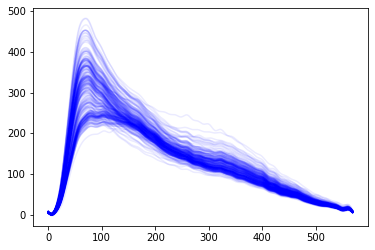

In [ ]:
sa = plt.plot(np.transpose(samples), alpha=0.08, color='blue')

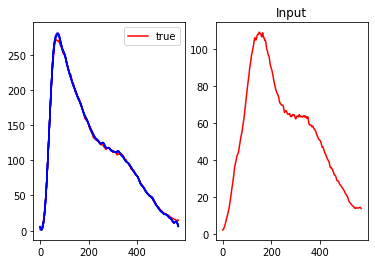

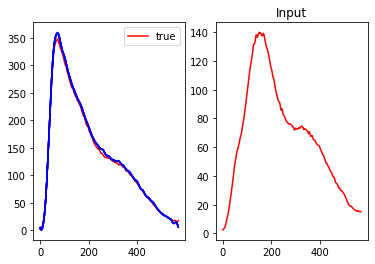

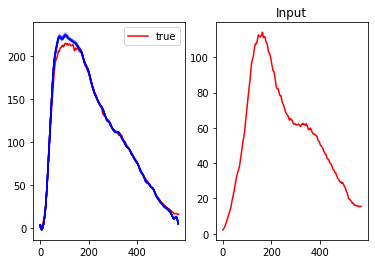

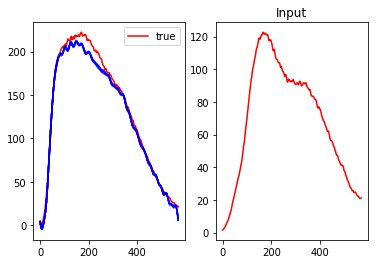

In [ ]:
n = 1
sample_condition = np.zeros((50,condition_scaled.shape[1]))
for i in range(50):
  sample_condition[i,:] = condition_scaled[n,:]

samples = sample_C_vae(Reg_CVAE.decoder, prior, 50, sample_condition, for_inversion, 5, tf_prob=False, normalise_fourier=scaler_output, normalise_path=1)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sugar_spectra[n,:,0], color='red', label='true')
ax1.plot(np.transpose(samples), alpha=0.1, color='blue')
ax1.legend(loc='upper right')
ax2.set_title('Output')

ax2.plot(sugar_spectra[n,:,1], color='red', label='true')
ax2.set_title('Input')
plt.show()

n = 100
sample_condition = np.zeros((50,condition_scaled.shape[1]))
for i in range(50):
  sample_condition[i,:] = condition_scaled[n,:]

samples = sample_C_vae(Reg_CVAE.decoder, prior, 50, sample_condition, for_inversion, 5, tf_prob=False, normalise_fourier=scaler_output, normalise_path=1)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sugar_spectra[n,:,0], color='red', label='true')
ax1.plot(np.transpose(samples), alpha=0.1, color='blue')
ax1.legend(loc='upper right')
ax2.set_title('Output')

ax2.plot(sugar_spectra[n,:,1], color='red', label='true')
ax2.set_title('Input')
plt.show()

n = 261
sample_condition = np.zeros((50,condition_scaled.shape[1]))
for i in range(50):
  sample_condition[i,:] = condition_scaled[n,:]

samples = sample_C_vae(Reg_CVAE.decoder, prior, 50, sample_condition, for_inversion, 5, tf_prob=False, normalise_fourier=scaler_output, normalise_path=1)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sugar_spectra[n,:,0], color='red', label='true')
ax1.plot(np.transpose(samples), alpha=0.1, color='blue')
ax1.legend(loc='upper right')
ax2.set_title('Output')

ax2.plot(sugar_spectra[n,:,1], color='red', label='true')
ax2.set_title('Input')
plt.show()

n = 267
sample_condition = np.zeros((50,condition_scaled.shape[1]))
for i in range(50):
  sample_condition[i,:] = condition_scaled[n,:]

samples = sample_C_vae(Reg_CVAE.decoder, prior, 50, sample_condition, for_inversion, 5, tf_prob=False, normalise_fourier=scaler_output, normalise_path=1)

f, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(sugar_spectra[n,:,0], color='red', label='true')
ax1.plot(np.transpose(samples), alpha=0.1, color='blue')
ax1.legend(loc='upper right')
ax2.set_title('Output')

ax2.plot(sugar_spectra[n,:,1], color='red', label='true')
ax2.set_title('Input')
plt.show()

### Conditional VAE to augment data set to increase accuracy of classifier

Text(0, 0.5, 'Electricity')

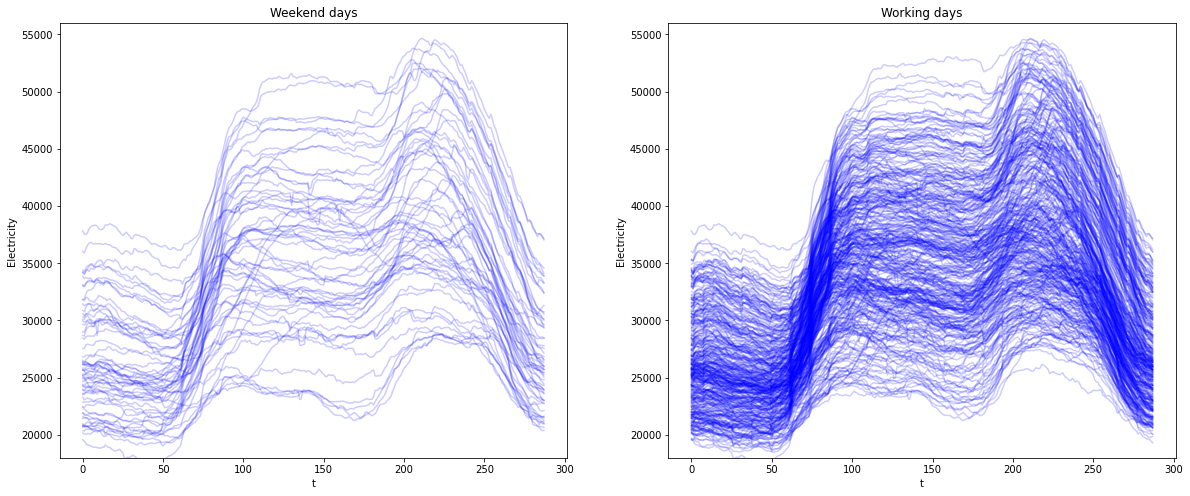

In [ ]:
fig, [ax0, ax1] = plt.subplots(1,2, figsize=(20,8))
ax0.plot(np.transpose(X_grid[weekdays == 1 ]), color='blue', alpha= 0.2)
ax0.set_title('Weekend days')
ax0.set_xlabel('t')
ax0.set_ylabel('Electricity')
ax0.set_ylim((18000, 56000))

ax1.plot(np.transpose(X_grid[weekdays < 5 ]), color='blue', alpha= 0.2)
ax1.set_ylim((18000, 56000))
ax1.set_title('Working days')
ax1.set_xlabel('t')
ax1.set_ylabel('Electricity')

In [ ]:

samples = results['grid_fpca'][0]['conditional']

X_train = X_grid_train
X_test = X_grid_test
X_test = np.expand_dims(X_test, -1)
y_train = np.sum(c_grid_train[:,:5], 1) # label 1 is week day and 0 is weekend
y_test = np.sum(c_grid_test[:,:5], 1)
y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc = enc.fit(y_train)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

b = 20
test_accuracies = []
# base data set labels
# loop adding more and more data until have equally sized classes
for i in range(8):
  # extract with correct label from samples
  augment = samples[341+i*b:(341+(i+1)*b)]
  # sample n from underrepresented category
  
  augment_labels = np.zeros((augment.shape[0], 2))
  X_train = np.squeeze(X_train)
  # add sampled to original data set with right label
  X_train = np.concatenate([X_train, augment], axis=0)
  X_train = np.expand_dims(X_train, axis=-1)
  
  y_train = np.concatenate([y_train, augment_labels], axis=0)
  print(y_train.shape)
  model_lstm = keras.Sequential()
  model_lstm.add(
      keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=20, 
            input_shape=[X_train.shape[1], X_train.shape[2]]
        )
      )
  )
  model_lstm.add(keras.layers.Dropout(rate=0.5))
  model_lstm.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
  model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  # train classifier
  history = model_lstm.fit(
        X_train, y_train,
        epochs=6,
        batch_size=40,
        validation_data= (X_test, y_test),
        shuffle=True
    )
  test_accuracies.append(history.history['val_acc'][-1])


(392, 2)
Epoch 1/6
10/10 [==============================] - 10s 312ms/step - loss: 0.7500 - acc: 0.4413 - val_loss: 0.7518 - val_acc: 0.3625
Epoch 2/6
10/10 [==============================] - 2s 162ms/step - loss: 0.7274 - acc: 0.4796 - val_loss: 0.7257 - val_acc: 0.3625
Epoch 3/6
10/10 [==============================] - 2s 165ms/step - loss: 0.6953 - acc: 0.4872 - val_loss: 0.7057 - val_acc: 0.3625
Epoch 4/6
10/10 [==============================] - 2s 162ms/step - loss: 0.6966 - acc: 0.4490 - val_loss: 0.6901 - val_acc: 0.6375
Epoch 5/6
10/10 [==============================] - 2s 163ms/step - loss: 0.6637 - acc: 0.5281 - val_loss: 0.6791 - val_acc: 0.6375
Epoch 6/6
10/10 [==============================] - 2s 160ms/step - loss: 0.6389 - acc: 0.5459 - val_loss: 0.6712 - val_acc: 0.6375
(412, 2)
Epoch 1/6
11/11 [==============================] - 6s 237ms/step - loss: 0.7830 - acc: 0.4951 - val_loss: 0.7320 - val_acc: 0.3625
Epoch 2/6
11/11 [==============================] - 2s 158ms/step

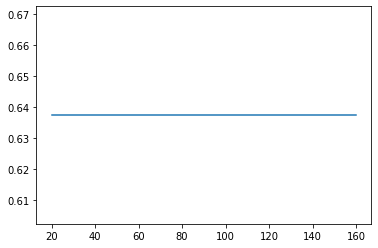

In [ ]:
plt.plot( [20, 40, 60, 80, 100, 120, 140, 160] , test_accuracies)
plt.title

### improve sugar ash content classifier


In [ ]:
# load sugar response: ash content
file_name='./drive/My Drive/ThesisData/Sugar_csv/response'
response_sugar = pd.read_csv(file_name)

In [ ]:
response_sugar = response_sugar['x']

In [96]:

print(np.max(response_sugar))
print(np.sum(response_sugar >18))

33
31


Text(0, 0.5, 'Count')

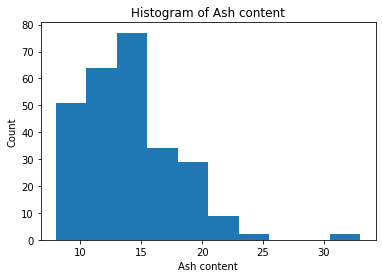

In [ ]:
plt.hist(response_sugar)
plt.title('Histogram of Ash content')
plt.xlabel('Ash content')
plt.ylabel('Count')

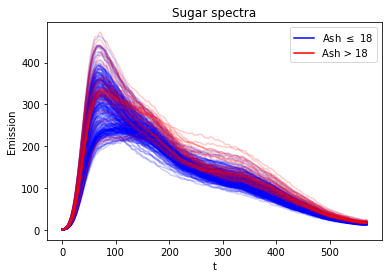

In [114]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], color='blue', label=r'Ash $\leq$ 18'),
                   Line2D([0], [0], color='red', label='Ash > 18')]

# Create the figure
low = plt.plot(np.transpose(sugar_spectra[:,:-1, 0][response_sugar <= 18]), color='blue', alpha=0.2 )
high = plt.plot(np.transpose(sugar_spectra[:,:-1, 0][response_sugar > 18]), color='red', alpha=0.2)
plt.legend(handles=legend_elements, loc='upper right')
plt.title('Sugar spectra')
plt.xlabel('t')
plt.ylabel('Emission')
#plt.legend([low, high], [r'Ash $\leq$ 18', 'Ash > 18'])
plt.show()

In [ ]:
ash_label = (response_sugar > 18) # one if ash content above 20, 0 otherwise
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
ash_label = np.expand_dims(ash_label,-1)
enc = enc.fit(ash_label)
ash_label = enc.transform(ash_label) # (1,0) for low ash, and (0,1) for high ash

Performing training and analysis on sugar
Epoch 1/400
27/27 [==============================] - 3s 4ms/step - loss: 187.5986
Epoch 2/400
27/27 [==============================] - 0s 6ms/step - loss: 85.8970
Epoch 3/400
27/27 [==============================] - 0s 6ms/step - loss: 95.8509
Epoch 4/400
27/27 [==============================] - 0s 7ms/step - loss: 78.4458
Epoch 5/400
27/27 [==============================] - 0s 6ms/step - loss: 56.6639
Epoch 6/400
27/27 [==============================] - 0s 7ms/step - loss: 79.6024
Epoch 7/400
27/27 [==============================] - 0s 6ms/step - loss: 58.4836
Epoch 8/400
27/27 [==============================] - 0s 7ms/step - loss: 53.9981
Epoch 9/400
27/27 [==============================] - 0s 6ms/step - loss: 57.9175
Epoch 10/400
27/27 [==============================] - 0s 5ms/step - loss: 48.3811
Epoch 11/400
27/27 [==============================] - 0s 6ms/step - loss: 46.5612
Epoch 12/400
27/27 [==============================] - 0s 6ms/ste

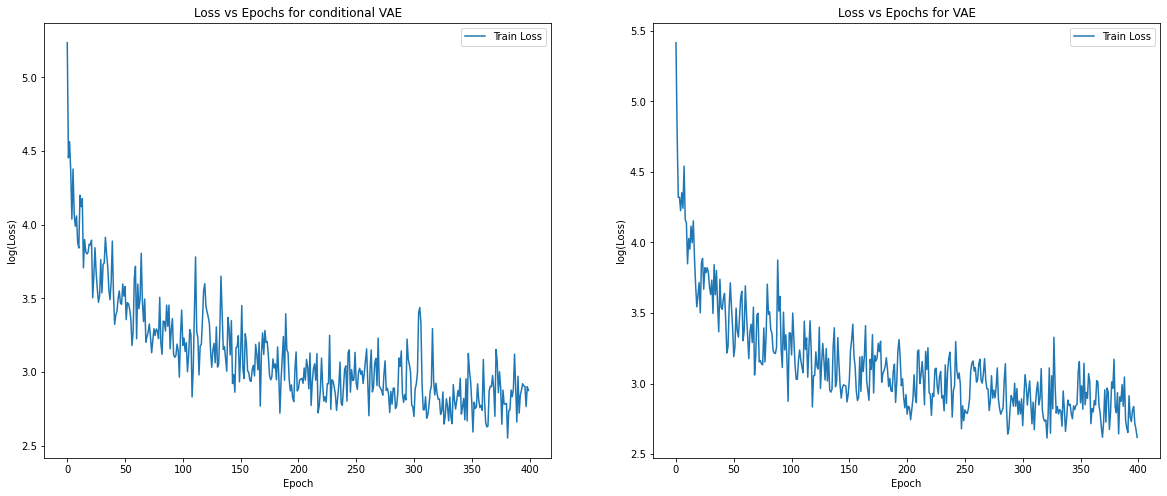

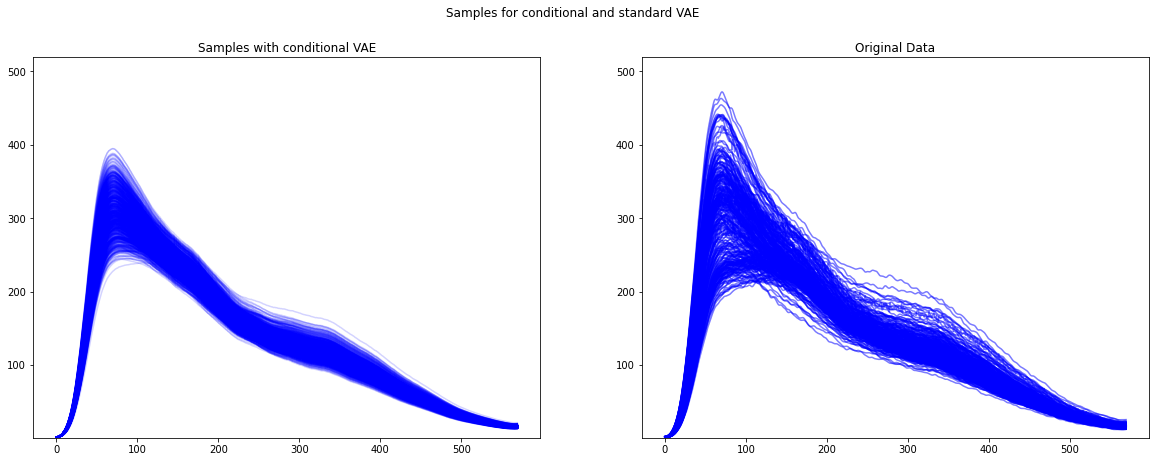

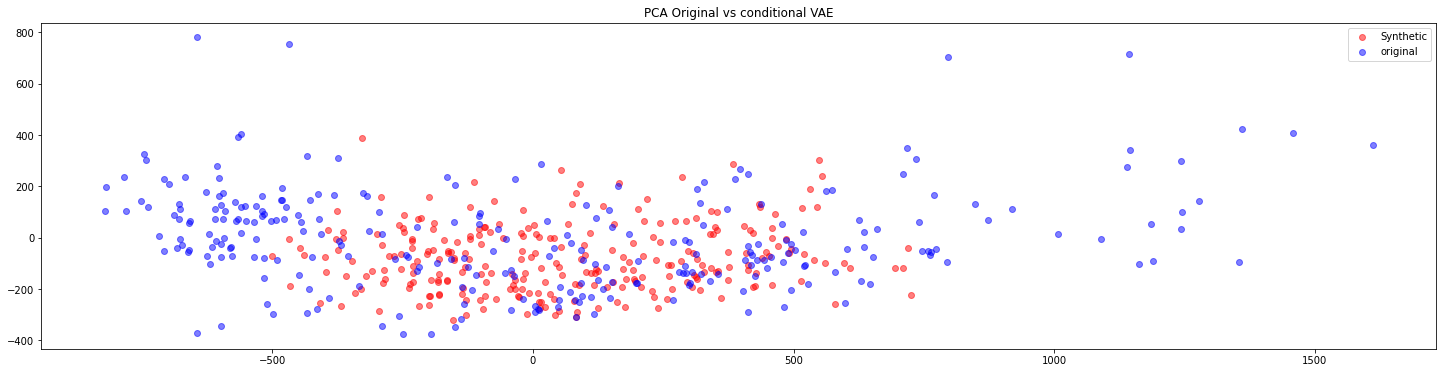

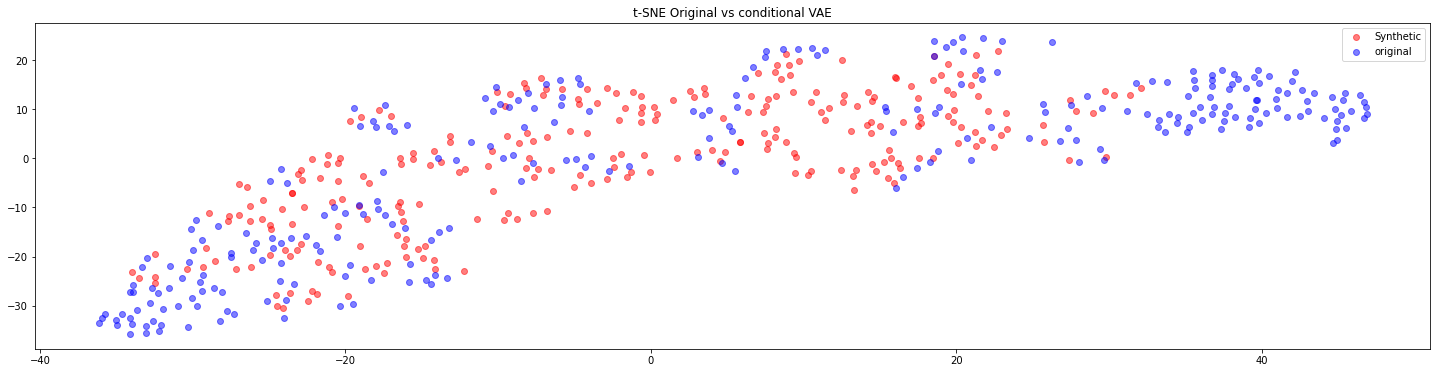

computing MMD
MMD between original data and 804 samples with conditional model is: 0.0


In [101]:
results_class = train_and_analyse(sugar_spectra[:,:-1, 0], ash_label, 'sugar', model_types=['conditional'],
                      validation_split=None, batch_size=10, 
                      num_samples=3, num_epochs=400, num_freq=100, 
                      latent_dims = 5, method = 'fpca')

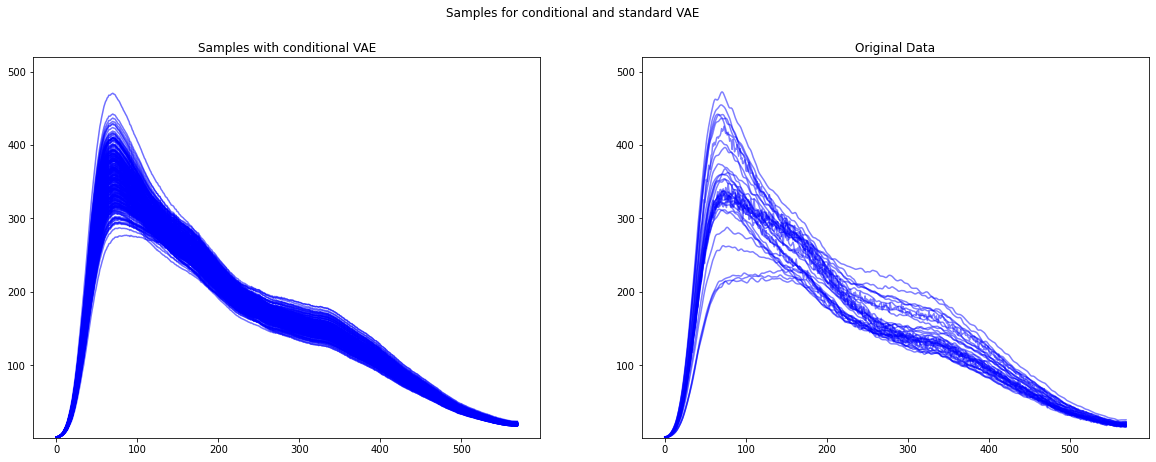

In [102]:
#augment_model = results_class[2]['conditional']
upsampled_labels = np.zeros((250,2))
upsampled_labels[:,1] = np.ones(250)

samples = sample_plot(upsampled_labels, results_class[2], results_class[4], results_class[5], model_types=['conditional'], original=sugar_spectra[:,:-1, 0][response_sugar>18], method='fpca', latent_dims = 5)

#upsampled_labels = np.zeros((100,2))
#upsampled_labels[:,0] = np.ones(100)

#samples = sample_plot(upsampled_labels, results_class[2], results_class[4], results_class[5], model_types=['conditional'], original=sugar_spectra[:,:-1, 0][response_sugar<=18], method='matern', latent_dims = 5)

In [103]:

X_train, X_test, y_train, y_test = train_test_split(sugar_spectra[:,:-1, 0], ash_label, stratify=ash_label[:,1], test_size=0.5, random_state=2)

X_test_high = X_test[y_test[:,1]==1]
y_test_high = y_test[y_test[:,1]==1]
num_high_test = X_test_high.shape[0]

X_test_low = X_test[y_test[:,1]==0]
y_test_low = y_test[y_test[:,1]==0]

X_test = np.concatenate([X_test_high,X_test_low[:num_high_test,:]], axis=0)
y_test = np.concatenate([y_test_high,y_test_low[:num_high_test,:]], axis=0)

X_train = np.concatenate([X_train,X_test_low[num_high_test:,:]], axis=0)
y_train = np.concatenate([y_train,y_test_low[num_high_test:,:]], axis=0)

X_test = np.expand_dims(X_test, -1)
X_train = np.expand_dims(X_train, -1)


b = 30
test_accuracies = []
# base data set labels
# loop adding more and more data until have equally sized classes
for i in range(7):
  # extract with correct label from samples
  X_to_add = samples['conditional'][i*b:((i+1)*b),:]
  # sample n from underrepresented category
  labels_to_add = upsampled_labels[:b,:]
  
  model_lstm = keras.Sequential()
  model_lstm.add(
      keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=20, 
            input_shape=[X_train.shape[1], X_train.shape[2]]
        )
      )
  )
  model_lstm.add(keras.layers.Dropout(rate=0.5))
  model_lstm.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
  model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
  # train classifier
  history = model_lstm.fit(
        X_train, y_train,
        epochs=6,
        batch_size=40,
        validation_data= (X_test, y_test))
  test_accuracies.append(history.history['val_acc'][-1])

  X_train = np.squeeze(X_train)
  # add sampled to original data set with right label
  X_train = np.concatenate([X_train, X_to_add], axis=0)
  X_train = np.expand_dims(X_train, axis=-1)
  
  y_train = np.concatenate([y_train, labels_to_add], axis=0)


Epoch 1/6
6/6 [==============================] - 13s 1s/step - loss: 0.8440 - acc: 0.4496 - val_loss: 0.6841 - val_acc: 0.5333
Epoch 2/6
6/6 [==============================] - 4s 580ms/step - loss: 0.5754 - acc: 0.6975 - val_loss: 0.7462 - val_acc: 0.5000
Epoch 3/6
6/6 [==============================] - 3s 580ms/step - loss: 0.5000 - acc: 0.7689 - val_loss: 0.8741 - val_acc: 0.5000
Epoch 4/6
6/6 [==============================] - 3s 456ms/step - loss: 0.3460 - acc: 0.9034 - val_loss: 1.0157 - val_acc: 0.5000
Epoch 5/6
6/6 [==============================] - 2s 294ms/step - loss: 0.3377 - acc: 0.9034 - val_loss: 1.1473 - val_acc: 0.5000
Epoch 6/6
6/6 [==============================] - 2s 299ms/step - loss: 0.2836 - acc: 0.9286 - val_loss: 1.2493 - val_acc: 0.5000
Epoch 1/6
7/7 [==============================] - 6s 419ms/step - loss: 0.6895 - acc: 0.5560 - val_loss: 0.7356 - val_acc: 0.5000
Epoch 2/6
7/7 [==============================] - 2s 297ms/step - loss: 0.5575 - acc: 0.7612 - val_l

Text(0.5, 0, 'Ratio of class counts in training Data')

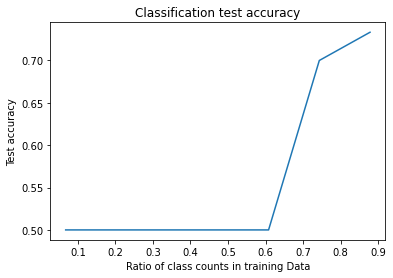

In [107]:
plt.plot((np.arange(0,7)*30+15)/222 , test_accuracies)
plt.title('Classification test accuracy')
plt.ylabel('Test accuracy')
plt.xlabel('Ratio of class counts in training Data')